# Förderhinweis

Dieses Dokument ist Teil des Lehrmaterials für die Fortbildung zum/zur **Berufsspezialist/in KI und Maschinelles Lernen.** 

Die Entwicklung und Erprobung dieses Bildungsangebotes wurde vom Bundesministerium für Bildung und Forschung im Rahmen des InnoVET-Programms gefördert.

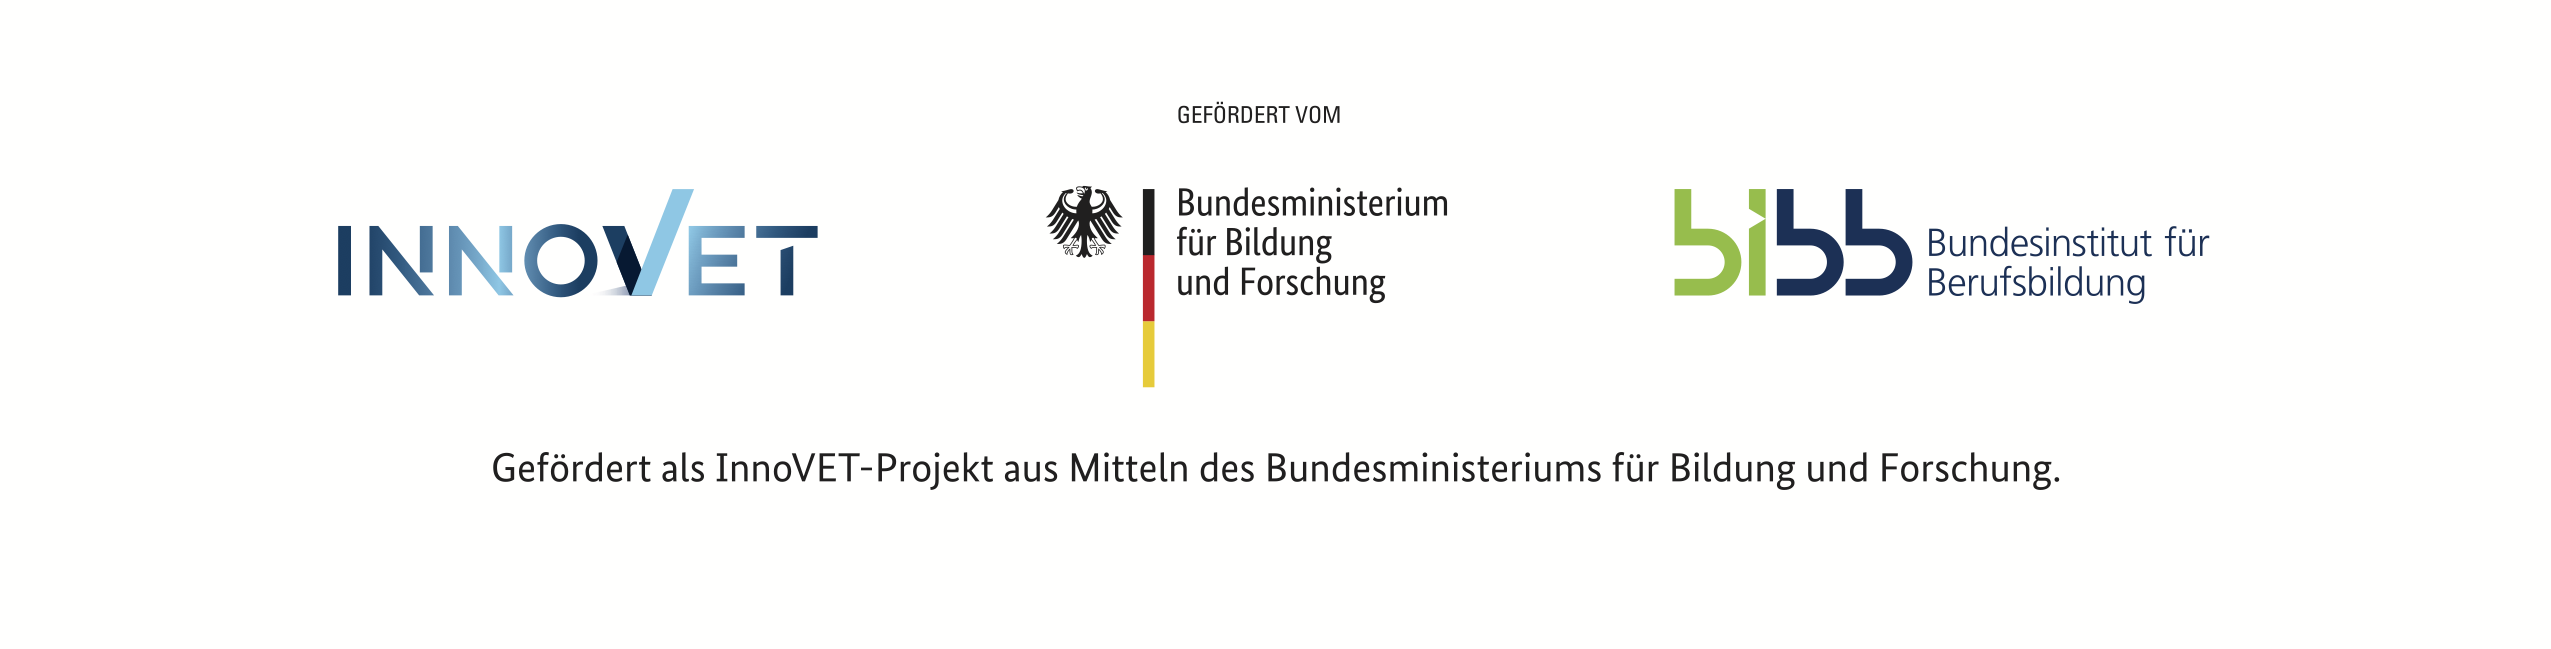

# Lizenzhinweis

Dieses Notebook "Predictive Maintenance: Fehlererkennung mit CNNs" wurde von Antje Schweitzer, KI B3 / Universität Stuttgart, erstellt. 

Das Werk, mit Ausnahme der oben abgebildeten Förderlogos, ist lizenziert unter [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/deed.de) (Namensnennung 4.0 International).

Die Idee zu diesem Projekt sowie ein Teil der Programmierbefehle basieren auf einem Notebook von Marco Cerliani (© 2022), das unter MIT Lizenz steht. Vereinfacht gesagt, erlaubt diese Lizenz die Verwendung im vorliegenden Notebook, wenn der Hinweis auf die Lizenz des Original-Notebooks beibehalten wird. Die genauen Lizenzbedingungen der MIT Lizenz finden Sie im letzten Abschnitt [Lizenzbedingungen des ursprünglichen Notebooks von Marco Cerliani](#Lizenzbedingungen-des-ursprünglichen-Notebooks-von-Marco-Cerliani).  

Die Befehle wurden von Antje Schweitzer überarbeitet und modifiziert. Die Erläuterungen wurden umfassend erweitert und ins Deutsche übersetzt. 

# Themen in diesem Notebook

* Daten laden
* Tensoren umformen
* Daten skalieren
* Neuronale Netze konfigurieren und trainieren
* Konvolution
* Max Pooling, Global Pooling
* Precision, Recall, Accuracy berechnen
* Konfusionsmatrix 
* Komplexität von Modellen
* Bewertung der Performanz
* Modellkomplexität und Performanz

# Ziel dieses Projekts

Bei diesem Notebook geht es darum, anhand von Sensordaten vorherzusagen, welche Komponenten eines Systems kurz vor dem Ausfall sind. Dies ist eine typische Aufgabe aus dem Bereich **Predictive Maintenance**. In diesem Notebook wird dafür ein Convolutional Neural Network (kurz: CNN) verwendet. 

Das Vorgehen wird exemplarisch für zwei Komponenten eines hydraulischen Systems illustriert: eine Kühlkomponente und ein Ventil. Der verwendete Datensatz enthält potentiell Daten von weiteren Komponenten, die ggf. in einem eigenen Projekt weiter untersucht werden können. Das heißt, bei Bedarf kann das hier gezeigte Projekt selbständig erweitert werden.

Zum Training des CNNs wird hier die Bibliothek *Keras* als nutzerfreundliches Interface zur Deep-Learning-Bibliothek *Tensorflow* verwendet. 

# Bibliotheken laden

In [ ]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Datenvorverarbeitung und Modellevaluierung
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

# Deep Learning
import tensorflow
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *

# Die Daten

## Temperaturdaten laden

Die Daten stammen aus folgender Quelle: 

__[Condition monitoring of hydraulic systems Data Set](https://archive.ics.uci.edu/ml/datasets/Condition+monitoring+of+hydraulic+systems)__

Laden Sie die Daten herunter (der direkte Link zum Download ist __[hier](https://archive.ics.uci.edu/ml/machine-learning-databases/00447/data.zip)__). Legen Sie im Verzeichnis mit diesem Notebook ein Unterverzeichnis namens `data` an und entpacken sie die heruntergeladene Datei `data.zip` dort. Wir gehen in diesem Notebook davon aus, dass die Daten in diesem Unterverzeichnis liegen.  

Falls Sie dieses Notebook auf einem Linux-Rechner oder bei Google Colabs ausführen, können Sie statt dessen auch einfach folgende Befehle ausführen, die die Datei laden, im Verzeichnis `data` speichern und dort auch auspacken:

In [ ]:
# Datei data.zip laden
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00447/data.zip -P data
# Datei auspacken
!cd data; unzip data.zip

Achtung, wenn Sie obige Befehle ausgeführt haben und sie noch einmal ausführen, existiert bereits eine Datei `data.zip` in Ihrem Verzeichnis `data`. In diesem Fall wird die Datei beim Herunterladen `data.zip.1` benannt. Der Befehl zum Auspacken geht aber davon aus, dass die Datei `data.zip` heißt. Löschen Sie daher ggf. `data.zip`, bevor Sie die Befehle erneut ausführen, oder führen Sie die Befehle nur einmal aus. 

Die Befehle mit dem Ausrufezeichen oben sind keine python-Befehle, sondern Befehle für das Betriebssystem Linux (dieses Betriebssystem wird auch bei Google Colabs genutzt). Sie funktionieren deshalb nicht unbedingt, wenn Sie dieses Notebook auf Ihrem eigenen Rechner ausführen, falls Sie kein Linux verwenden. In dem Fall sollten Sie die Dateien daher statt dessen selbst laden und in einem Verzeichnis speichern wie oben beschrieben.


**Anmerkung für Nutzer*innen bei Google Colabs**

---

Falls Sie das Notebook bei Google Colabs bearbeiten, legen die obigen Befehle ein temporäres Verzeichnis `data` an und entpacken die Daten dort. Sie können diese Daten sehen, wenn Sie in der Seitenleiste von Google Colabs (ganz links) auf das Ordnersymbol klicken. Dort sollten ein Verzeichnis `data` angezeigt werden, das Sie anklicken können. Sie finden darin die geladene Datei sowie weitere Dateien mit der Endung `.txt`. Es ist möglich, diese Dateien dort zu löschen. Bei Ende der Colab-Sitzung werden sie automatisch gelöscht. Sie müssen also bei jeder neuen Sitzung in Google Colabs die Befehle wieder neu ausführen. 

Falls Sie die Daten lieber dauerhaft in Ihrem Google Drive speichern wollen, fügen Sie statt dessen eine Zelle mit folgendem Code ein:

```
from google.colab import drive
drive.mount('/content/drive')
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00447/data.zip -P /content/drive/My\ Drive/Colab\ Notebooks/data
!cd /content/drive/My\ Drive/Colab\ Notebooks/data; unzip data.zip
```

Führen Sie diese Befehle aus. Achtung, Sie müssen im Rest des Notebooks dann aber Ihre Variable `data_dir` anpassen auf `/content/drive/My\ Drive/Colab\ Notebooks/data`.

---



Bei Predictive Maintenance ist das Ziel häufig, den "Leistungszustand" einer Komponente vorherzusagen. Bei diesem Datensatz handelt es sich um den Leistungszustand von vier Komponenten eines Hydrauliksystems: dem Kühler, eines Ventils, der Hydraulikpumpe und des Hydraulikspeichers. 

Der Datensatz wurde eigens erstellt, um Trainingsdaten zur Erkennung des Zustands der Komponenten zu erhalten. Das Hydrauliksystem wurde mit verschiedenen Sensoren ausgestattet. Dann wurden der Ausfall oder der drohende Ausfall der Komponenten simuliert. Dafür wurden gezielt einzelne oder mehrere Komponenten in Zyklen von je einer Minute manipuliert. Während jedes Zyklus wurden mithilfe der Sensoren Daten gesammelt. Da die Komponenten gezielt manipuliert wurden, sind in jedem Zyklus die korrekten Zustände bekannt. Das Ziel des Trainings ist, an den Sensordaten zu erkennen, in welchem Zustand sich die Komponenten befinden. 

 Die korrekten Zustände (und damit die später vorherzusagenden Klassen) dieser Komponenten stehen bei diesen Daten in der Datei *profile.txt*. Sie enthält 2205 Zeilen, die den Werten für die 2205 Zyklen entsprechen. Die Werte sind in fünf Spalten aufgeteilt. In den ersten vier Spalten stehen die Zustände der vier Komponenten. In der fünften Spalte wurden außerdem Zyklen markiert, in denen das System möglicherweise noch keinen stabilen Zustand erreicht hatte: wo dies der Fall war, steht in der fünften Spalte eine eins (1). Fälle, in denen das System stabil war, sind dagegen mit 0 in der fünften Spalte markiert. 

Wir laden die Zustände samt der Markierung für Stabilität in einen DataFrame und benennen die Spalten dabei entsprechend. Anschließend schauen wir uns beispielhaft die Werte für Zyklus 2200 an. 

In [ ]:
# Verzeichnis für Daten festlegen
data_dir = 'data'
# Achtung, falls Sie die Daten dauerhaft in Ihrem Google Drive haben, 
# verwenden Sie bitte statt dessen folgende Zeile:
# data_dir = '/content/drive/My Drive/Colab Notebooks/data'

### vorherzusagende Klassen laden ###
label = pd.read_csv(data_dir + '/profile.txt', sep='\t', header=None)
# Spalten benennen
label.columns = ['Kühler','Ventil','Pumpe','Hydrospeicher','instabil']

# exemplarisch die Klassen für Zyklus 2200 ausgeben lassen
print(label.loc[2200])

# und die ersten fünf Zeilen des DataFrames anschauen 
# (also die Klassen für die Zyklen 0 bis 4)
label.head()

Dieser Ausgabe kann man entnehmen, dass die ersten fünf Zyklen alle die Zustände 3 für den Kühler, 100 für das Ventil, 0 für die Pumpe, 130 für den Hydrospeicher aufweisen. Außerdem sind alle als potentiell instabil markiert: die Werte in der Spalte für Instabilität sind alle 1. 

Bei diesen Werten handelt es sich also um die Klassen (oder auch: die Targets), die wir später vorhersagen wollen. Laut Beschreibung der Daten (siehe Datei *description.txt* im Verzeichnis *data*) gibt es folgende Zustände für die vier Systemkomponenten:

|Kühler|Ventil|Pumpe|Hydrospeicher| 
|-----|:-----|:---|:-----|
|100: voll effizient |100: schaltet optimal  |0: kein Leck|130: optimaler Druck|
|20: reduziert|90: kurze Verzögerung| 1: kleines Leck| 115: leicht red. Druck| 
|| 80: stärkere Verzögerung || 100: stark red. Druck|
|3: kurz vor Ausfall|73: kurz vor Ausfall|2: großes Leck|90: kurz vor Ausfall|


Als nächstes laden wir die Messwerte, mit deren Hilfe wir die Zustände vorhersagen wollen. Sie sind also die Features für die Vorhersage. 
Wir verwenden dafür zunächst nur die Messwerte von vier Temperatursensoren. Die Sensoren heißen TS1, TS2, TS3 und TS4. Die Werte sind in vier verschiedenen Dateien im Verzeichnis *data* gespeichert. Jede dieser Dateien enthält eine Tabelle mit 2205 Zeilen (entsprechend 2205 Zyklen). Jede Zeile hat 60 Messwerte. Diese sind die von den Sensoren während des Zyklus einmal pro Sekunde gemessenen Temperaturen. Eine Messung einmal pro Sekunde entspricht einer Frequenz von 1 Hertz (1 Hz). Dies wird später noch wichtig, weil die Daten der anderen Sensoren teilweise mit höheren Frequenzen gemessen wurden. 

Die Messwerte in den Zeilen sind bei den vorliegenden Daten durch Tabulator-Zeichen voneinander getrennt. Dieses Format nennt man "CSV-Format" (für comma-separated values, also "durch Komma getrennte Werte"). Das gilt auch in unserem Fall, auch wenn hier statt Kommas Tabulator-Zeichen verwendet wurden. Der einfachste Weg, in python solche Dateien einzulesen, ist mithilfe der Funktion `read_csv` aus der `pandas`-Bibliothek. Man kann dort auch gleich spezifizieren, welches Trennzeichen vorliegt - wir werden hier `\t` verwenden, die Bezeichnung für das Tabulator-Zeichen.  

Es handelt sich um vier verschiedene Dateien. Deshalb erstellen wir erst eine Liste, die vier DataFrames enthält - einen pro Datei. Anschließend nutzen wir die Funktion `concat` aus der `pandas`-Bibliothek, um aus der Liste von DataFrames einen großen DataFrame zu machen. 

Zuletzt zeigen wir den DataFrame an, um einen Eindruck zu bekommen, wie die Daten aussehen. 

In [ ]:
### Messwerte laden ###
files_1Hz = ['TS1.txt','TS2.txt','TS3.txt','TS4.txt']

# leere Liste vorbereiten
list_of_df_frames = []

# Daten laden und DataFrames an Liste anhängen
for file in files_1Hz:
    df_tmp = pd.read_csv(data_dir+'/'+file, sep='\t', header=None)
    list_of_df_frames.append(df_tmp)

# Liste der DataFrames zu einem langen DataFrame machen
df = pd.concat(list_of_df_frames, ignore_index=False)

# anzeigen
df

Wir haben jetzt 8820 Zeilen mit Datenreihen von jeweils 60 Werten (für je 60 Sekunden). Die ersten 2205 Datenreihen (hier also Zeilen) sind von Sensor 1, die nächsten von Sensor 2, usw. Dabei bestehen die 2205 Datenreihen pro Sensor jeweils aus Datenreihen aus aufeinanderfolgenden Zyklen. 

Es ergibt sich momentan also folgende Struktur: Wir haben in Dimension 0 (den Zeilen) sowohl unterschiedliche Zyklen als auch unterschiedliche Sensoren. In Dimension 1 (den Spalten) haben wir den Zeitpunkt innerhalb der Zyklen (in Sekunden). Das kann man auch an der Ausgabe von `df.shape` erkennen: (8820, 60) bedeutet 8820 Werte in Dimension 0 und 60 Werte in Dimension 1. Die 8820 ergeben sich, weil wir 4*2205 Werte eingelesen haben. 

In [ ]:
df.shape

## Daten neu strukturieren

Wir verwenden als nächstes die Funktion `reshape`, um die Dimensionen Zyklus und Sensor zu trennen. 

Wir haben die Daten der Sensoren in vier Blöcken eingelesen. Das bedeutet, zuerst kommen alle Daten zu Sensor 1, dann die zu Sensor 2, usw. Die erste Dimension besteht also aus 4 längeren Blöcken, die den Sensoren entsprechen. Innerhalb dieser Blöcke kommen erst die 60 Werte vom ersten Zyklus, dann die 60 Werte vom zweiten Zyklus usw. Wir haben daher auch innerhalb jedes Blockes eine Gruppierung, und zwar nach Zyklen. Diese stellen die zweite Dimension dar. Und innerhalb jedes dieser Zyklen liegen 60 Werte vor, die die dritte Dimension ergeben. 

Stellen wir also diese Struktur mithilfe von `reshape` her. Die gewünschte Form ist, wie eben bestimmt, (4,2205,60) - erst die Sensoren, dann die Zyklen, dann die Zeitpunkte. Die Funktion stammt aus der `numpy`-Bibliothek und kann nicht auf DataFrames angewandt werden, sondern nur auf Arrays. Wir wandeln daher den DataFrame in ein Array um, indem wir nur die Werte (*values*) des DataFrames verwenden. Das sieht so aus:

In [ ]:
df.values

Auf das Ergebnis kann direkt `reshape` angewandt werden. Wir speichern das Resultat nun auch gleich in einer Variable namens `data`.

In [ ]:
data = df.values.reshape(4,2205,60)
data.shape

Der Code oben funktioniert, wenn man 4 Werte in Dimension 0, 2205 Werte in Dimension 1 und 60 Werte in Dimension 2 hat. Wenn man sich nicht genau auf 4, 2205 und 60 festlegen will, geht es auch flexibler. Schließlich wäre es ja möglich, dass wir in Zukunft andere Daten einlesen, die Zeilen- oder Spaltenanzahlen haben. Auch könnte man eine andere Anzahl von Sensoren haben. Wir hatten die Werte für die Sensoren in einer Schleife aus unterschiedlichen Dateien gelesen und dabei in einer Liste von DataFrames gesammelt. Die Länge dieser Liste, `len(list_of_df_frames)`, ergibt deshalb die korrekte Anzahl an Sensoren (hier 4) und damit die korrekte Menge an Werten für die erste Dimension. Die Anzahl der Spalten des DataFrames, den wir daraus zusammengebaut haben, ergibt dagegen die Anzahl von Werten pro Zyklus, und kann mit `len(df.columns)` aus dem DataFrame abgelesen werden. Dies ergibt die korrekte Anzahl an Werten für die dritte Dimension. 

Es fehlt dann nur noch die Anzahl an Datenreihen pro Zyklus, also die zweite Dimension. Da wir die Werte für die anderen beiden Dimensionen schon kennen, muss man diese nicht explizit bestimmen. Statt dessen kann man der Funktion `reshape()` an dieser Stelle -1 als Argument übergeben - dann wird dieser Wert automatisch so bestimmt, dass alle verfügbaren Werte verbraucht werden. Im vorliegenden Fall ist es zum Beispiel so, dass wir insgesamt `2205*4*60=529200` einzelne Werte haben. Wenn diese alle in drei Dimensionen verteilt werden sollen und dabei die erste und dritte Dimension 4 bzw. 60 lang sein sollen, dann ergibt sich zwangsläufig, dass in der zweiten Dimension 2205 Werte verteilt werden müssen.  

In [ ]:
data = df.values.reshape(len(list_of_df_frames),-1,len(df.columns))
data.shape

Es fehlt noch ein letzter Schritt, bevor wir die Daten in der perfekten Form haben. Für das Training wollen wir die Daten für einen Zyklus als eine Einheit betrachten. Daher sollten die Zyklen die erste Dimension darstellen, in Python-Nummerierung also als Dimension 0. Und für die grafische Darstellung ist es sinnvoll, die Zeit als Dimension 1 und die Sensoren als Dimension 2 zu verwenden (jeweils in Python-Nummerierung). Das erreichen wir durch das Anhängen von `.transpose(1,2,0)` an den bisherigen Ausdruck: dadurch bekommen wir zuerst die bisherige Dimension 1, dann die bisherige Dimension 2, dann die bisherige Dimension 0. Wir können die korrekte Reihenfolge anschließend mithilfe von `shape` noch einmal überprüfen. 

In [ ]:
data = df.values.reshape(len(list_of_df_frames),-1,len(df.columns)).transpose(1,2,0)
data.shape

## Daten genauer ansehen

Wir sehen uns zunächst einige Datenpunkte an. Der folgende Code stellt die Entwicklung der Sensorwerte innerhalb eines Zyklus dar. Sie sollten hier immer 4 Linien sehen; eine pro Sensor. Jede Linie stellt dar, wie sich die Temperatur an diesem Sensor im Lauf der 60 Sekunden verändert. In der Überschrift sehen Sie den Zustand des Kühlers. 

Sie sehen unten Grafiken für 10 Zyklen. Damit man hier nicht nur die allerersten 10 Zyklen in den Daten ansieht, wurde die Variable `offset` eingeführt - dadurch werden immer 10 Zyklen ab dem Index mit dem für `offset` angegeben Wert angezeigt. Wenn Sie mit 0 als Wert für den Offset starten, sehen Sie die ersten 10 Zyklen - hier ist in allen Fällen der Zustand des Kühlers 3, also kurz vor dem Ausfall. Darauf weisen auch die steigenden Temperaturwerte der Sensoren hin. Probieren Sie andere Werte für den Offset aus, um Zyklen zu sehen, in denen der Kühler funktioniert. 

In [ ]:
# Sensordaten von 10 aufeinanderfolgenden Zyklen grafisch darstellen
# offset gibt den Index an, ab dem die Daten gezeigt werden sollen
offset = 0
for index in range(10):
    plt.figure(figsize=(8,5))
    plt.plot(data[index+offset])
    plt.title('Kühler: '+str(label.loc[index+offset]['Kühler']))
    plt.ylabel('Sensorwerte'); plt.xlabel('Zyklus')

# Trainings- und Testdaten vorbereiten

## Klassen vorbereiten

Der nächste Schritt ist, die Daten für das Training vorzubereiten. Als erstes bereiten wir einen Vektor mit den korrekten Klassen für den Zustand des Kühlers vor. Wir haben oben bereits die Zustände sämtlicher Sensoren in einen DataFrame namens `label` geladen. Wir extrahieren daraus die Spalte für den Kühler und speichern das Ergebnis in einer Variable namens `target` - diese beinhaltet also die Klassen, die wir vorhersagen wollen. 

In [ ]:
# Spalte für den Kühler in Vektor target speichern
target = label.Kühler
target.value_counts()

Dieser Vektor ist für die Klassifizierung in einem neuronalen Netz noch nicht geeignet. Wir haben hier einen Vektor, der für jeden Zyklus einen Wert enthält: entweder 3 oder 20 oder 100. Bei einem Drei-Klassen-Problem wie hier sollte der Output der obersten Schicht aber drei Werte liefern - jeder der drei Werte gibt die Wahrscheinlichkeit an, mit der der Input zu einer der drei Klassen gehört. Wir brauchen also 3 Werte pro Zyklus.

Die 3 Werte sollten zudem nicht Klassen sein, sondern Wahrscheinlichkeiten. Angenommen, wir klassifizieren mit dem Netz Input, der zur dritten von drei Klassen gehört. Wenn alles gut läuft, könnte das Netz z.B. als Output [0.1, 0.2, 0.7] liefern. Das würde bedeuten, das Input gehört mit einer Wahrscheinlichkeit von 0.1 (10%) zur ersten Klasse, mit einer Wahrscheinlichkeit von 0.2 (20%) zur zweiten Klasse, und am wahrscheinlichsten, mit 0.7 (70%) zur dritten Klasse. Im Anwendungsfall würde man dann als Vorhersage die wahrscheinlichste Klasse nehmen, und in diesem Fall wäre die Vorhersage dann auch korrekt. 

Für das Training muss die Vorgabe für die korrekte Klassifizierung dasselbe Format haben wie der gewünschte Output - hier also ein Vektor von drei Werten, die zusammen 1 (100%) ergeben. Wenn es sich bei dem Input um ein Exemplar der dritten Klasse handelt, sollte daher die Vorgabe für das Training so aussehen: [0, 0, 1]. Das bedeutet, beim Input handelt es sich sicher nicht (0% Wahrscheinlichkeit) um Klasse 1 oder 2, sondern mit Sicherheit (1, also 100% Wahrscheinlichkeit) um Klasse 3. 

Bei den möglichen Klassen 3, 20 und 100 benötigen wir also als gewünschtes Ergebnis statt eines Vektors wie 

```
[  3, 3, 100, 20, ... , 20 ] 
```
eine Matrix wie 

```
[ [ 1, 0, 0 ]
  [ 1, 0, 0 ]
  [ 0, 0, 1 ]
  [ 0, 1, 0 ]
  ...
  [ 0, 1, 0 ] ]
```
Hier entspricht die erste Zeile [1, 0, 0] dem ersten Wert im Vektor: die Klasse 3 ist die erste Klasse, und daher haben wir hier eine 1 beim ersten Element. Zeile 3, [0, 0, 1], entspricht dem dritten Element des Vektors - bei 100 handelt es sich um die dritte der drei Klassen, daher steht die 1 an der dritten Stelle. 

Wir wandeln zuerst die vorliegenden Werte 3, 20, und 100 in die Werte 0, 1, und 2 um. Dies erledigen wir in 2 Schritten: wir erstellen erst ein Dictionary, in dem man nachsehen kann, welcher Wert in welchen umgewandelt werden muss. Dabei erstellen wir auch gleich ein Dictionary, in dem man nachsehen kann, wie die Umwandlung rückgängig gemacht werden kann. 

In der Schleife unten liefert `target.unique()` die drei vorkommenden Klassen 3, 20 und 100. Mit dem `enumerate(target.unique())` bekommt man diese durchnummeriert: das Ergebnis sind drei Tupel (0,3), (1, 20) und (2, 100). 

In [ ]:
for tupel in enumerate(target.unique()):
    print(tupel)

Mit dieser Konstruktion können so die beiden Dictionaries zum Hin- und Herwandeln erstellt werden (`target_label` und `target_reverse_label`).

In [ ]:
# Dictionaries zum Umwandeln

# leere Dictionaries
target_label, target_reverse_label = {}, {}
# Dictionaries füllen
for i,lab in enumerate(target.unique()):
    target_label[lab] = i
    target_reverse_label[i] = lab

print(target_label)
print(target_reverse_label)


Wir verwenden jetzt das Dictionary, um die Werte im Target-Vektor in Werte zwischen 0 und 2 umzuwandeln. Anschließend macht die Funktion `to_categorical()` aus dem Vektor eine Matrix, bei der in jeder Zeile dasjenige Element auf 1 gesetzt wird, das der jeweiligen Zahl entspricht. Wir haben danach also eine Matrix mit 2205 Zeilen (eine pro Zyklus) und 3 Spalten (mit einer eins in der jeweils korrekten Spalte).

In [ ]:
target = target.map(target_label)
y = to_categorical(target)
print(y.shape)
y

## Aufteilen in Test- und Trainingsdaten

In [ ]:
# Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(data, y, random_state = 42, test_size=0.2)
X_train.shape

## Skalierung der Daten

Als nächstes skalieren wir die Werte wie üblich so, dass der Mittelwert in den Daten 0 ist, und dass die Daten die Standardabweichung 1 haben. Dadurch sind z.B. Werte, die unter dem Durchschnitt liegen, kleiner als Null, und die meisten Werte sind zwischen -1 und 1. Das ist für das Training vorteilhaft. Hierbei ist es sinnvoll, die Werte der vier Sensoren getrennt zu skalieren - schließlich ist es informativ zu wissen, ob ein Wert z.B. kleiner ist als der Durchschnitt für diesen Sensor. Dadurch lassen sich Abweichungen am Sensor direkt entdecken. Weniger informativ wäre es, zu wissen, ob der Wert kleiner ist als der Durchschnitt über alle Sensoren - es könnte sich ja um einen Sensor handeln, der generell niedrigere Werte liefert als die anderen. 

Wir haben früher schon die Funktion `StandardScaler()` zum Skalieren von Daten verwendet, allerdings immer mit zweidimensionalen Daten in DataFrames. Dafür ist die Funktion auch gedacht - sie geht davon aus, dass zusammengehörende Datenpunkte in Zeilen angeordnet sind und in den Spalten verschiedene Features stehen. Dann wird jede Spalte separat skaliert. 

Wir müssen daher unsere Daten für die Skalierung noch einmal umformen: statt den drei Dimensionen (Zyklus, Zeitpunkt, Sensor) brauchen wir zwei Dimensionen, und die zweite Dimension, also die Spalten, sollen die Sensoren sein. Dadurch werden die Werte für jeden Sensor separat skaliert - wie gewünscht. 

Wir verwenden dazu `reshape()`. Als zweites Argument geben wir `X_train.shape[-1]` an, das liefert den korrekten Wert für die letzte Dimension, die Sensoren, hier also 4. Es ist praktischer, hier nicht von Hand 4 einzutragen, sondern den Wert mithilfe von `shape` aus den Daten zu ermitteln; dadurch funktioniert der Code auch noch, wenn sich die Zahl der Sensoren ändern sollte. Als erstes Argument verwenden wir wieder -1. Dadurch bestimmt das `reshape()` die korrekte Anzahl selbst - die Zahl ergibt sich ja aus der Zahl der vorhandenen Werte geteilt durch 4.

Das Ergebnis der Umformung kann man bei Bedarf in der nächsten Zelle überprüfen:

In [ ]:
X_train.reshape(-1, X_train.shape[-1])

Wir initialisieren jetzt das Skalierer-Objekt und lassen Mittelwerte und Standardabweichungen mithilfe von `fit()` auf den wie oben beschrieben umgeformten Daten berechnen. Anschließend wird die Skalierung mit diesen Werten durch `transform()` erst auf die Trainingsdaten und dann auf die Testdaten angewandt - beide müssen dazu durch das `reshape()` umgewandelt werden. Direkt nach dem `transform()` wird durch das Anhängen von `.reshape(X_train.shape)` wieder in die ursprüngliche Form (nämlich `X_train.shape` bzw. `X_test.shape`) zurückgewandelt. 

In [ ]:
# Daten skalieren
scaler = StandardScaler()
# Mittelwerte und Standardabweichungen berechnen und in Skalierer speichern
scaler.fit(X_train.reshape(-1, X_train.shape[-1]))
# auf Daten anwenden
X_train = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


# Kühlermodell trainieren und evaluieren

## Model konfigurieren

Das Notebook, auf dem dieses Notebook hier basiert, verwendet für diese Daten ein Modell, das auf der Keras-Website als ein Standard-Modell vorgeschlagen wird. Wir verwenden zunächst das gleiche Modell. 

Es besteht aus insgesamt 8 Schichten über der Input-Schicht. Die ersten beiden Schichten sind zwei Konvolutionsschichten. Beide enthalten 100 verschiedene Filter, die jeweils 6 nacheinander auftretende Werte erfassen. Die Skizze zeigt das Input und die erste Konvolutionsschicht, allerdings für 10 statt für 100 Filter. Man kann der Skizze entnehmen, dass der Output der ersten Konvolutionsschicht die Dimensionen (55, 100) haben muss: da die Filterkerne die Länge 6 haben und nicht über das Ende des Inputs "hinaus" geschoben werden können, liefert jeder Filterkern nur 55 statt 60 Werte. Aufgrund der 100 Filterkerne ergibt sich für die zweite Dimension die Länge 100 (in der Skizze Länge 10 bei 10 Filterkernen).

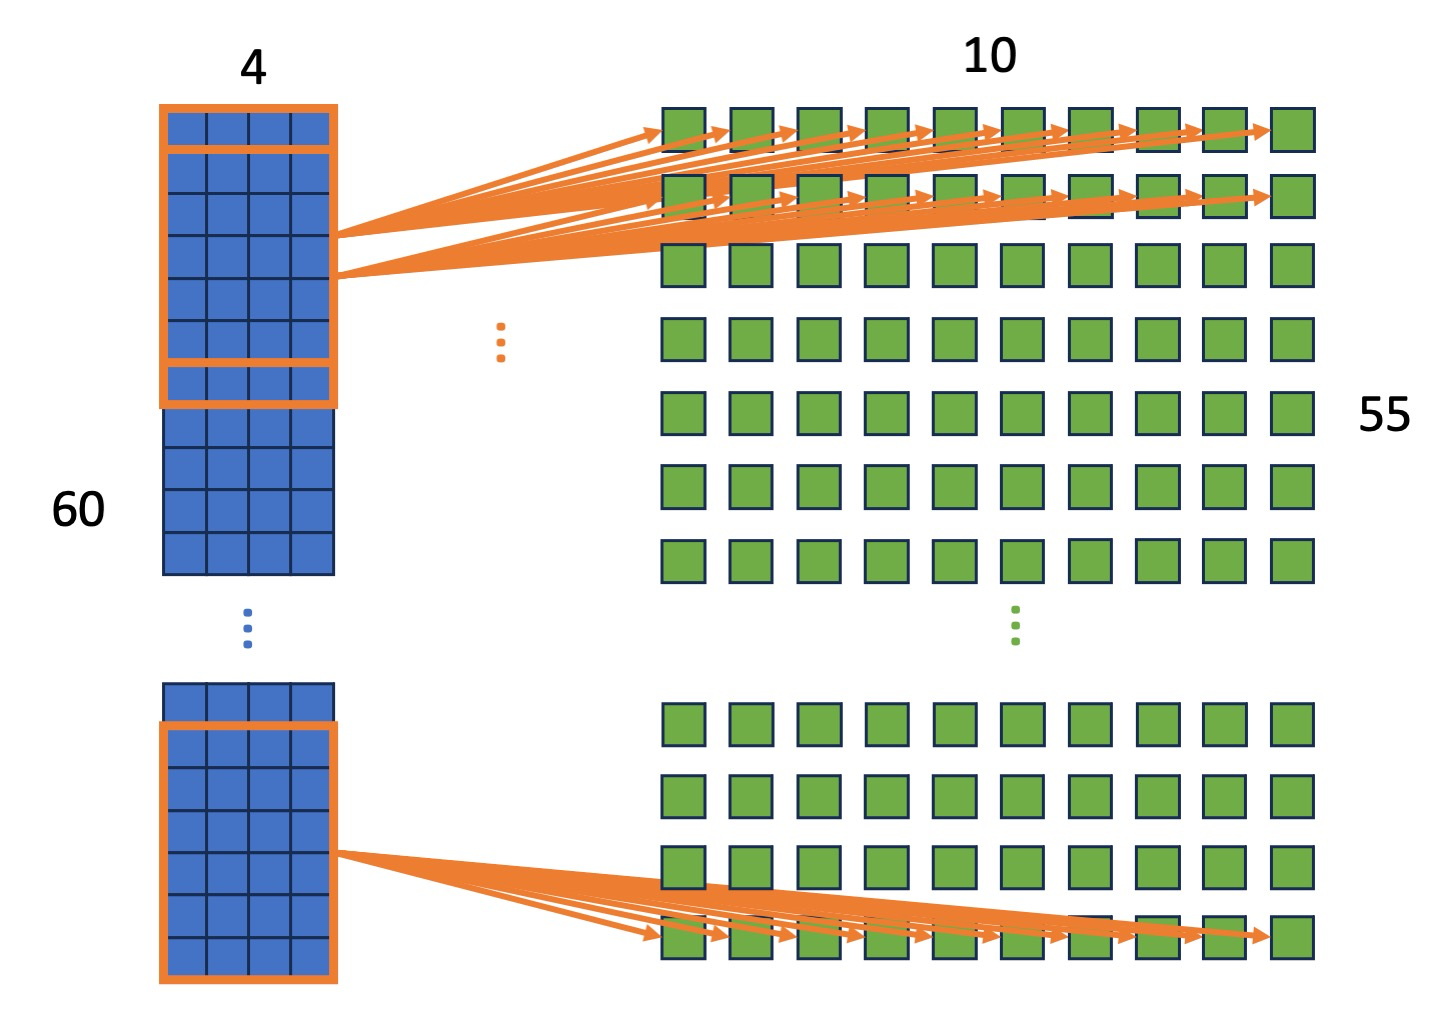

Mindestens beim ersten Entwurf eines CNNs ist es sinnvoll, die Architektur Schicht für Schicht aufzubauen und sich dabei die Form der Outputs anzusehen. Mit Keras kann man mithilfe von `add` die Schichten nacheinander hinzufügen und zwischendurch mithilfe von `summary()` die Form der Outputs überprüfen. 

In [ ]:
num_sensors = 4
TIME_PERIODS = 60

# Modell initialisieren
model_cooler = Sequential()
# erste Schicht anlegen, hierbei muss die Form des Inputs angegeben werden
# wir nutzen als Aktivierung ReLU
model_cooler.add(Conv1D(100, 6, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))

model_cooler.summary()

Diesen Angaben kann man entnehmen, dass die Form des Outputs der ersten Schicht (None, 55, 100) ist. Die erste Dimension, deren Länge hier noch unbekannt ist (daher 'None'), wird automatisch angelegt, sie ermöglicht es, immer mehrere Trainingsbeispiele gleichzeitig in einem Batch zu verarbeiten. Die zweite Dimension ist wie erwartet 55. Die dritte Dimension 100 ergibt sich aus der Anzahl der Filterkerne. 

Wir sehen auch die Anzahl der Parameter, die für diese Schicht trainiert werden müssen: 2500. Dies ergibt sich folgendermaßen: jeder der Filterkerne umfasst 6x4 Input-Werte, also 24 (in anderen Worten, es gibt 24 Verbindungen von der Input-Schicht zur Konvolutionsschicht, für die die Gewichte bestimmt werden müssen). Dazu kommt noch der Bias, wir haben also pro Filterkern 25 Werte und damit insgesamt 2500 Werte. Durch das Bewegen der Filterkerne durch den Input (also durch das Weiterschieben des Fensters) kommen keine neuen Gewichte dazu, denn es werden dieselben Gewichte genutzt, egal, wo der Filterkern im Input positioniert ist.  

Wir legen eine weitere Konvolutionsschicht an. 

In [ ]:
model_cooler.add(Conv1D(100, 6, activation='relu'))
model_cooler.summary()

Für die zweite Schicht ergeben sich mehr Parameter: diesmal umfasst jeder Filterkern 6x100 Werte statt wie in der ersten Schicht 6x4. Das liegt daran, dass das Output der ersten Schicht die Form (6,100) hat und nicht mehr (6,4) wie das Input. Das ergibt diesmal 600 Werte pro Filterkern, bzw. 601 mit dem Bias, und daher insgesamt 60100 Werte bei 100 Filterkernen. 

Die Form des Outputs der zweiten Konvolutionsschicht ist folgendermaßen: Wir haben hier entlang der Zeitdimension noch 50 Zeitpunkte. Das liegt daran, dass wir aufgrund der Kernlänge von 6 wieder 5 Werte am Ende "verlieren". Wir bekommen aber wieder eine zweite Dimension mit je 100 Werten, da wir wieder 100 Filterkerne verwendet haben. Der Output dieser zweiten Konvolutionsschicht hat daher die Form (50, 100).

Die nächste Schicht darüber ist eine MaxPooling-Schicht mit Fensterlänge 3. Die MaxPooling-Schicht fasst  mehrere aufeinanderfolgende Werte entlang der ersten Dimension zusammen - in unserem Fall immer drei. Dabei wird einfach nur der größte der drei Werte behalten. Die Grafik unten illustriert dies.

![skizze.MaxPooling.png](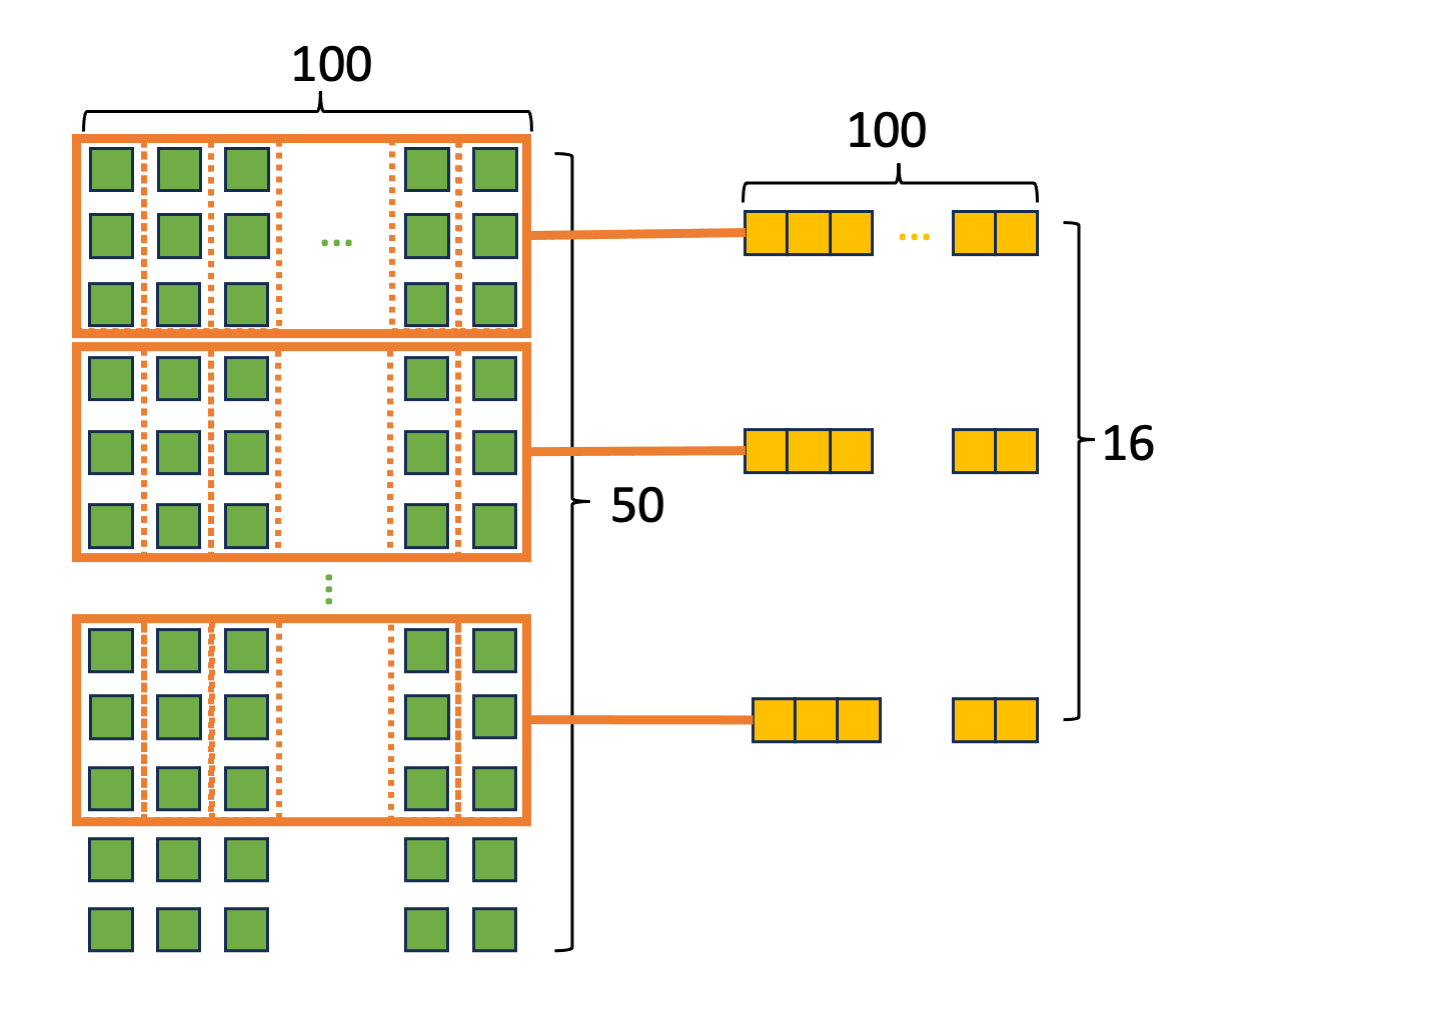
)


Durch das MaxPooling wird pro Filterkern immer das Maximum aus 3 Zeitpunkten verwendet. Anschließend haben wir also statt je drei "Zeilen" für 3 Zeitpunkte mit 100 Filterkernen nur noch eine Zeile mit 100 Filterkernen. Durch das Zusammenfassen von je 3 Zeitpunkten können wir 16 * 3 = 48 Zeitpunkte erfassen - die letzten beiden Zeitpunkte werden ignoriert, da sie kein Fenster der Länge drei mehr ergeben. Wir erhalten also 16 mal je 100 Werte, wie in der obigen Skizze dargestellt. Die grünen Zellen entsprechen dem Output der Konvolutionsschicht. In den orangenen MaxPooling-Fenstern wird in jeder Spalte das Maximum übernommen. Dadurch ergibt sich pro Fenster eine orangefarbene Zeile mit 100 Werten. 

Bei der MaxPooling-Schicht gibt es keine Gewichte, es wird ja einfach nur das Maximum ausgewählt. Dadurch müssen aber auch keine Parameter trainiert werden. Das kann man in der Zusammenfassung des Modells sehen - in der Spalte für die Parameter steht dort 0. 

In [ ]:
model_cooler.add(MaxPooling1D(3)) # weglassen
model_cooler.summary()

Wir ergänzen zwei weitere Konvolutionsschichten, die diesmal je 160 Filterkerne enthalten und wieder die Länge 6 haben. Dadurch reduziert sich die Länge der zeitlichen Dimension weiter von 16 auf 6. 

Die Anzahl der Parameter für die erste der beiden Schichten ist 96160: pro Filterkern werden 6 * 100 Gewichte benötigt plus der Bias, also pro Filterkern 601 Parameter, insgesamt also 601 * 160 = 96160. In der zweiten Schicht sind es dagegen 6 * 160 Gewichte plus der Bias, also 961, und insgesamt 961 * 160 = 153760.

Anschließend fügen wir eine sogenannte GlobalAveragePooling-Schicht ein - diese berechnet für jeden der 160 Filterkerne den Mittelwert über die 6 Zeitpunkte. Übrig bleiben also nur noch 160 Werte - der Output hat nur noch eine Dimension. Wie bei der MaxPooling-Schicht müssen auch für die AveragePooling-Schicht keine Parameter gelernt werden.

In [ ]:
model_cooler.add(Conv1D(160, 6, activation='relu')) # weglassen
model_cooler.add(Conv1D(160, 6, activation='relu')) # weglassen
model_cooler.add(GlobalAveragePooling1D(name='G_A_P_1D'))


Das Netzwerk wird abgeschlossen von einer Dropout-Schicht. Diese Schicht ist nur für das Training relevant. Sie bewirkt, dass ein bestimmter Anteil der Werte, die aus der darunter liegenden Schicht kommen, zufällig auf Null gesetzt werden. Wir verwenden hier 0.5 als Anteil, der auf Null gesetzt werden soll. Diese Technik dient dazu, Overfitting zu vermeiden und macht insofern das Netzwerk insgesamt robuster. Wir werden in einem späteren Notebook noch auf Overfitting und Dropout eingehen. 

Die Dropout-Schicht hat keine trainierbaren Parameter und verändert auch die Form nicht. 

Abschließend kommt eine Schicht, in der alle Neuronen der vorigen Schicht mit allen Neuronen der neuen Schicht verbunden sind - dies wird als *fully connected* (Deutsch: "voll verbunden"), oder auch *dense* (Deutsch: "dicht") bezeichnet. Hier muss angegeben werden, wie viele Neuronen in der neuen Schicht gewünscht sind. Da wir ein Klassifizierungsproblem mit 3 Klassen haben, verwenden wir hier 3. Dadurch ergeben sich zu jedem der 3 Neuronen in der letzten Schicht 160 Verbindungen aus der Schicht darunter, plus der Bias, also 3 * 161 = 483 Parameter. Die Form des finalen Outputs in der obersten Schicht ist ein Vektor der Länge 3 - pro Klasse ein Wert. Da wir als Aktivierungsfunktion `softmax` verwenden, handelt es sich bei diesen Werten um die Klassenwahrscheinlichkeiten. 

In [ ]:
model_cooler.add(Dropout(0.5))
model_cooler.add(Dense(3, activation='softmax'))
model_cooler.summary()

Das Modell ist damit fertig konfiguriert. Es verwendet insgesamt 313003 Parameter, die beim Training gelernt werden müssen. 

## Training


Es fehlt nun noch die Konfiguration fürs Training. Wir wählen hier Standard-Parameter: Als Verlustfunktion die Kreuzentropie, und beim Training soll die Accuracy zur Evaluierung verwendet werden. 

Es muss außerdem ein Optimierer ausgewählt werden. Der Optimierer bestimmt, auf welche Weise beim Training die besten Parameter für das Netzwerk gefunden werden. Hierbei werden immer die Gradienten der Verlustfunktion verwendet, um die Richtung zu bestimmen, in der die Parameter angepasst werden sollen. Wie genau diese aber verwendet werden, ist unterschiedlich, es gibt verschiedene bekannte Algorithmen für die Anpassung. Ein häufig genutzter Algorithmus ist *Adam* (kurz für *Adaptive Moment Estimation*). 

In [ ]:
# Konfiguration fürs Training
model_cooler.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Der nächste Schritt ist das Training. Für das Training haben wir seit der Aufteilung in Trainings- und Testdaten nicht mehr 2205 Datenpunkte zur Verfügung, sondern nur noch 1764 (der Rest wird für das Testen benötigt). Falls Sie daran zweifeln: probieren Sie `X_train.shape`.

Hier sollen immer 16 Trainingsdatenpunkte gleichzeitig verwendet werden, d.h. es wird in Batches von je 16 trainiert. Wir legen außerdem noch fest, dass 20% der Daten zur Validierung verwendet werden (`validation_split=0.2`). Damit bleiben 1411 Datenpunkte fürs Training.  Das Training soll 10 Epochen lang durchgeführt werden - d.h. alle 1411 Datenpunkte werden 10 mal für die Anpassung der Parameter verwendet werden. 

In [ ]:
BATCH_SIZE = 16
EPOCHS = 10

history = model_cooler.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=2, )

Das Modell ist nun fertig trainiert. In den allermeisten Fällen ist dieses Modell praktisch perfekt. Man kann dann direkt sehen, dass es auf den Validierungsdaten schon in einer der ersten Epochen Accuracys von 100% (1.0) liefert. Der Verlust auf den Validierungsdaten ist sehr klein. 

Allerdings erzeugt jedes Training ein leicht anderes Modell. Das liegt daran, dass die Gewichte im Netzwerk anfangs per Zufall initialisiert werden. Jedes Training startet also mit einem anderen Ausgangsmodell. Es kommt mit der obigen Konfiguration manchmal vor, dass das Modell keine Accuracy von 100% aufweist, sondern nur fast 100%. Sie können in diesen Fällen die Zelle mit dem Training einfach noch einmal ausführen. Seien Sie sich aber bewusst, dass dies nicht notwendigerweise ein "besseres" Modell ergibt - es ergibt nur ein Modell, dass auf den für die Validierung verwendeten Daten zufällig minimal besser ist. 

## Evaluierung


Die exzellenten Werte aus dem Training haben noch lange nichts zu sagen - es könnte auch sein, dass das Modell unter Overfitting leidet, also überangepasst auf die Trainingsdaten ist. Wie gut es wirklich ist, lässt sich erst anhand der im Training nicht verwendeten Testdaten bewerten. Wir verwenden die Funktion `evaluate()`.

In [ ]:
model_cooler.evaluate(X_test, y_test, verbose=2)

Auch hier ist das Modell in den allermeisten Fällen wahnsinnig gut und erreicht eine Accuracy von 100%. Das bedeutet, dass keine Testdaten falsch klassifiziert werden. Das können wir auch mit weiteren Evaluationsmaßen sowie visuell bestätigen: sehen wir zunächst den `classification_report()` an, den Keras zur Verfügung stellt. Dafür müssen wir erst noch die vorhergesagten Klassen berechnen. Anschließend übergeben wir der Funktion ein Array mit den korrekten Klassen und eines mit den vorhergesagten Klassen. 

In [ ]:
# Matrix mit vorhergesagten in Vektor umwandeln
# die Klasse ist jeweils der Index des Elements
# mit der höchsten Klassenwahrscheinlichkeit
# argmax für axis=1 liefert die Position des größten Elements pro Zeile
# wandelt z.B. Vorhersage [0.2, 0.7, 0.1] in die Position 1 um 
pred_test = np.argmax(model_cooler.predict(X_test), axis=1)

Wir können nun den `classification_report()` ausgeben lassen. Der Report verwendet die in den Testdaten vorhergesagten Werte 0, 1 und 2. Wir sehen darin verschiedene Evaluationsmaße für die drei Klassen. Allerdings muss man nun wissen, welcher der Werte zu welcher Klasse gehört. 

In [ ]:
# Matrix mit den korrekten Klassifizierungen   
# in einen Vektor umwandeln
y_classes = np.argmax(y_test,axis=1)
print(classification_report(y_classes, pred_test))

Noch einfacher zu interpretieren ist dies, wenn wir direkt die korrekten Klassennamen angegeben bekommen. Es gibt hier  die Möglichkeit, der Funktion `classification_report()` ein Argument mit den Bezeichnungen mitzugeben. Alternativ kann man die Vektoren, die man der Funktion übergibt, auch wieder auf die Originalnamen zurückmappen. Da wir diese Methoden später im Notebook noch einmal gut brauchen können, wählen wir diesen zweiten Weg. 

In [ ]:
# für jedes Element in y_classes im Dictionary target_reverse_label die Klasse nachschlagen
# und daraus einen neuen Vektor erzeugen
y_classes_original_label = [target_reverse_label[x] for x in y_classes]
# genauso für die vorhergesagten Klassen
pred_test_original_label = [target_reverse_label[x] for x in pred_test]

# classification report mit den gemappten Daten ausgeben
print(classification_report(y_classes_original_label, pred_test_original_label))

Es werden also alle Zustände des Kühlers gut erkannt. In den Testdaten waren 152 Fälle, wo der Kühler kurz vor Ausfall war (Label: 3). Wenn in der Spalte *Recall* der Werte 1.00 steht, bedeutet das, dass alle korrekt erkannt wurden. Wenn in der Spalte *Precision* der Wert 1.00 steht, bedeutet das, dass das Modell in allen Fällen, in denen es vermeintlich einen Ausfall erkannte, korrekt lag. Entsprechendes gilt für die Zeilen für die 135 Fälle mit dem nur bedingt funktionierenden Kühler (Label: 20) sowie für die 154 Fälle mit perfekt funktionierendem Kühler. 

Für die meisten mit dem obigen Code trainierten Modelle sollten Sie hier überall Werte von 1.00 sehen. Falls Sie andere Werte bekommen, können Sie alle Zellen vom Training bis hierher noch einmal ausführen, um möglicherweise ein "besseres" Modell zu bekommen. Achtung, es reicht nicht, nur das Training neu auszuführen - Sie müssen auch `pred_test` und `pred_test_original_label` neu erstellen lassen, sonst enthalten diese noch die Werte, die das alte Modell vorhergesagt hatte. 

Bitte vergessen Sie nicht, dass das nicht notwendigerweise ein "besseres" Modell ist - und dass man eigentlich "schummelt", wenn man Modelle, mit deren Evaluierungswerten man nicht zufrieden ist, einfach so lange neu trainiert, bis man gute Evaluierungswerte bekommt. Tun Sie dies hier also bitte nur, um Ergebnisse zu erhalten, die denen entsprechen, die hier vorgestellt werden, so dass Sie die Erklärungen nachvollziehen können.

Die Ergebnisse können auch sehr schön in einer Verwechslungsmatrix dargestellt werden. Diese kann man z.B. mit der Funktion `confusion_matrix` aus `sklearn` berechnen. Man sollte wissen, dass hierbei die Klassen aus dem Vektor mit den korrekten Klassen in sortierter Reihenfolge dargestellt werden. Wenn wir als Argument also `y_classes` übergeben, stellen die erste Zeile und die erste Spalte daher die Werte für die Klasse 0 dar, danach kommt Klasse 1, danach Klasse 2. Zufällig entspricht das auch der Reihenfolge der gemappten Klassen. Übergibt man also `y_classes_original_label`, so entspricht die erste Zeile der Klasse 3, die zweite der Klasse 20, die dritte der Klasse 100. In diesem Fall macht es also keinen Unterschied, ob die vorhergesagten Klassenindizes (0, 1, 2) oder die Original-Labels für die Klassen übergeben werden. Die Reihenfolge ist dieselbe.

In [ ]:
cnf_matrix = confusion_matrix(y_classes, 
                 pred_test)
print(cnf_matrix)

Diese Ausgabe ist in unserem Fall recht übersichtlich, allerdings muss man wissen, in welcher Reihenfolge die Klassen hier in den Zeilen und Spalten stehen. Etwas hübscher und mit etwas mehr Information bekommt man die Konfusionsmatrix mithilfe der Funktion `ConfusionMatrixDisplay()`, ebenfalls aus `sklearn`. Diese bekommt als Argumente die zuvor berechnete Konfusionsmatrix von oben übergeben. Wenn man nichts weiter übergibt, zählt sie die Klassen einfach von 0 bis 2 durch. Man kann aber die Namen der korrekten Klassen als Argument übergeben. Wir nutzen hier aus, dass diese im Dictionary `target_label` bereits in der richtigen Reihenfolge stehen - in sortierter Reihenfolge 3, 20, 100, und damit konsistent mit Sortierung der Zeilen und Spalten in der Konfusionsmatrix. Die Funktion erzeugt eine Grafik, die man anschließend mit `plt.show()` darstellen kann.

In [ ]:
target_label

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,display_labels=target_label).plot()
plt.show()

Man sieht die gleiche Information wie oben, aber es ist klarer, welche Information in den Spalten steht und welche in den Zeilen. Wie üblich ist es wünschenswert, dass hohe Zahlen nur in der Diagonalen auftreten. Dies ist bei der farbigen Version der Konfusionsmatrix besonders leicht zu überprüfen: die Diagonale sollte möglichst hell sein.  

# Ein einfacheres Kühlermodell

Das obige Modell ist für unser aktuelles Problem, das Erkennen von Kühlerausfällen, eigentlich viel zu komplex. Dies kann man erahnen, wenn man sich die Performanz anschaut - in fast allen Durchläufen bekommen wir ausnahmslos perfekte Vorhersagen, und das schon ab den ersten Epochen. Dies spricht dafür, dass einfachere Modell ausreichen könnten. Wir vereinfachen daher das bisherige Modell und eliminieren die beiden oberen Konvolutionsschichten. Damit können wir auch auf die MaxPooling-Schicht verzichten und den Output der 2. Konvolutionsschicht direkt in die AveragePooling-Schicht geben. 

Die neue Konfiguration sehen Sie hier:

In [ ]:
num_sensors = 4
TIME_PERIODS = 60

# Modell initialisieren
model_cooler2 = Sequential()
# erste Schicht anlegen, hierbei muss die Form des Inputs angegeben werden
# wir nutzen als Aktivierung ReLU
model_cooler2.add(Conv1D(100, 6, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_cooler2.add(Conv1D(100, 6, activation='relu'))
#model_cooler2.add(MaxPooling1D(3)) # eliminiert
#model_cooler2.add(Conv1D(160, 6, activation='relu')) # eliminiert
#model_cooler2.add(Conv1D(160, 6, activation='relu')) # eliminiert
model_cooler2.add(GlobalAveragePooling1D(name='G_A_P_1D'))
model_cooler2.add(Dropout(0.5))
model_cooler2.add(Dense(3, activation='softmax'))

model_cooler2.summary()

model_cooler2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Das neue Modell ist einfacher. Das sieht man vor allem an der Zahl der zu trainierenden Parameter: sie hat sich von 313003 auf 62903 reduziert. Dies wird sich auch bei der Trainingsdauer bemerkbar machen. Die Trainingsdauer sehen Sie nach dem Ausführen der Zelle mit dem Training in der Zelle angezeigt. Die Trainingsdauer ist natürlich von Rechner zu Rechner unterschiedlich. Der Rechner, auf dem dieses Notebook entwickelt wurde, brauchte für das Training des komplexeren Modells ca. 17 Sekunden, und für das Training des vereinfachten Modells ca. 13. 

In [ ]:

BATCH_SIZE = 16
EPOCHS = 10

history = model_cooler2.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=2)

In [ ]:
model_cooler2.evaluate(X_test, y_test, verbose=2)

In [ ]:
# die dieses Mal vorhergesagten Klassen speichern
# die Klasse ist jeweils der Index des Elements
# mit der höchsten Klassenwahrscheinlichkeit
pred_test2 = np.argmax(model_cooler2.predict(X_test), axis=1)

cnf_matrix2 = confusion_matrix(y_classes, 
                 pred_test2)

print(cnf_matrix2)

Das neue Modell scheint genauso gut zu sein wie das erste, komplexere Modell. Es liefert selten Evaluierungsergebnisse unter 1.00. 

Wir sehen uns deswegen an, ob das Modell weiter vereinfacht werden kann. Die bisherigen Modelle hatten in den beiden unteren Konvolutionsschichten Filterkerne der Länge 6, und zwar jeweils 100 solcher Filterkerne. Wir reduzieren diese Anzahl jetzt auf nur 10. 

In [ ]:
num_sensors = 4
TIME_PERIODS = 60

# Modell initialisieren
model_cooler3 = Sequential()
model_cooler3.add(Conv1D(10, 6, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_cooler3.add(Conv1D(10, 6, activation='relu'))
model_cooler3.add(GlobalAveragePooling1D(name='G_A_P_1D'))
model_cooler3.add(Dropout(0.5))
model_cooler3.add(Dense(3, activation='softmax'))

model_cooler3.summary()

model_cooler3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:

BATCH_SIZE = 16
EPOCHS = 10

history = model_cooler3.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=2)

Hier kommt man jetzt meist auf Accuracys von 98%, das ist immer noch sehr gut und kann für manche Anwendungsszenarien ausreichen. Das Training ist aber wesentlich schneller. Auf dem Rechner, der beim Erstellen des Notebooks genutzt wurde, dauerte es zum Beispiel weniger als 5 Sekunden. 

In [ ]:
model_cooler3.evaluate(X_test, y_test, verbose=2)

Selbst das stark vereinfachte Modell mit nur noch 893 Parametern liefert noch sehr, sehr gute Ergebnisse. Beim Entwickeln dieses Notebooks z.B. eine Klassifikationsgenauigkeit von 99.1%. Dies ist in vielen Anwendungen ein Traumergebnis. Wir sehen uns noch die Verwechslungsmatrix an, um diesen Eindruck zu visualisieren. 

In [ ]:
# vorhergesagte Klassen speichern
pred_test3 = np.argmax(model_cooler3.predict(X_test), axis=1)

cnf_matrix3 = confusion_matrix(y_classes, 
                 pred_test3)

ConfusionMatrixDisplay(confusion_matrix=cnf_matrix3, 
                       display_labels=target_label).plot()
plt.show()

Beim Entwickeln dieses Notebooks ergab das Training des vereinfachten Modells folgende Konfusionsmatrix, die hoffentlich sehr ähnlich aussieht wie die, die Sie oben erhalten haben:

<image alt="output.png" src="data:img/png;base64,iVBORw0KGgoAAAANSUhEUgAAAg0AAAGwCAYAAAAqpFaiAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAABA30lEQVR4nO3deXRU9f3/8ddkmywkIQkkIRIgStgXESiCVqAsioJw/FWkuGDFVmXRFBBrUQlVEvHbAgKKSy2kKKK1gtQqglVDKaIkgKyC1AhBiEEJ2cg6c39/REaHRe4wk8wk83ycc89h7v3MnfcwhHnn/dkshmEYAgAAuIAAbwcAAAAaB5IGAABgCkkDAAAwhaQBAACYQtIAAABMIWkAAACmkDQAAABTgrwdgC+w2+06evSoIiMjZbFYvB0OAMBFhmGotLRUSUlJCgion9+HKysrVV1d7ZF7hYSEKDQ01CP3akgkDZKOHj2q5ORkb4cBAHBTfn6+Wrdu7fH7VlZWKqVtMxUU2jxyv8TEROXl5TW6xIGkQVJkZKQk6YvcSxTZjB6bpu5XXX/m7RDQgIzaWm+HgAZQqxpt0juO/889rbq6WgWFNh3KbaeoSPe+J0pK7Wrb+ytVV1eTNDRGp7skIpsFuP2PAb4vyBLs7RDQgAy6HP3D9xsi1HcXc7NIi5pFuvcadjXef5MkDQAAmGQz7LK5uWOTzbB7JhgvIGkAAMAkuwzZ5V7W4O7zvYlaPAAAMIVKAwAAJtlll7udC+7fwXtIGgAAMMlmGLIZ7nUvuPt8b6J7AgAAmEKlAQAAk/x9ICRJAwAAJtllyObHSQPdEwAAwBQqDQAAmET3BAAAMIXZEwAAACZQaQAAwCT794e792isSBoAADDJ5oHZE+4+35tIGgAAMMlmyAO7XHomFm9gTAMAADCFSgMAACYxpgEAAJhil0U2Wdy+R2NF9wQAADCFSgMAACbZjbrD3Xs0ViQNAACYZPNA94S7z/cmuicAAIApVBoAADCJSgMAADDFblg8crhi48aNGjVqlJKSkmSxWLRmzZrztr3nnntksVi0cOFCp/NVVVWaOnWqWrRooYiICN144406cuSIy++fpAEAAB9WXl6unj17asmSJT/Zbs2aNfrkk0+UlJR01rW0tDStXr1aq1at0qZNm1RWVqaRI0fKZrO5FAvdEwAAmOTJ7omSkhKn81arVVar9az2I0aM0IgRI37ynl9//bWmTJmi9957TzfccIPTteLiYr300ktasWKFhg4dKkl6+eWXlZycrPfff1/XXnut6dipNAAAYJJNAR45JCk5OVnR0dGOIzMz86Jistvtuv322/Xggw+qa9euZ13Pzc1VTU2Nhg8f7jiXlJSkbt26afPmzS69FpUGAABMMi5iTMK57iFJ+fn5ioqKcpw/V5XBjHnz5ikoKEj333//Oa8XFBQoJCREMTExTucTEhJUUFDg0muRNAAA4AVRUVFOScPFyM3N1dNPP61t27bJYnEtmTEMw+Xn0D0BAIBJp8c0uHt4yn/+8x8VFhaqTZs2CgoKUlBQkA4dOqTp06erXbt2kqTExERVV1erqKjI6bmFhYVKSEhw6fVIGgAAMMlmBHjk8JTbb79dO3fu1I4dOxxHUlKSHnzwQb333nuSpN69eys4OFgbNmxwPO/YsWPavXu3BgwY4NLr0T0BAIAPKysr08GDBx2P8/LytGPHDsXGxqpNmzaKi4tzah8cHKzExER17NhRkhQdHa2JEydq+vTpiouLU2xsrGbMmKHu3bs7ZlOYRdIAAIBJdllkd7NIb5drO1bl5ORo8ODBjsfTpk2TJE2YMEHLly83dY8FCxYoKChIY8eOVUVFhYYMGaLly5crMDDQpVhIGgAAMMkby0gPGjRIhmE+0fjqq6/OOhcaGqrFixdr8eLFLr32mRjTAAAATKHSAACASZ4YyGhzoWrga0gaAAAwqW5Mg3vdE+4+35vongAAAKZQaQAAwCT7j/aOuPh70D0BAECTx5gGAABgil0BDb5Ogy9hTAMAADCFSgMAACbZDItsbm6N7e7zvYmkAQAAk2weGAhpo3sCAAA0dVQaAAAwyW4EyO7m7Ak7sycAAGj66J4AAAAwgUoDAAAm2eX+7Ae7Z0LxCpIGAABM8sziTo23yN94IwcAAA2KSgMAACZ5Zu+Jxvv7OkkDAAAm2WWRXe6OaWBFSAAAmjwqDWhSdm9pptVLW+l/u8J14psQ/eGlL3TldScd1xempeiDv7dwek6HXmX609v7HI9rqiz66+PJ2rgmVtWVAep5dYnuzTikFkk1DfU24AG3TD6mq647qdaXVaq6MkB7cyP018zWOvJlqLdDQz0ZOeFb3XzfccXG1+jQgVA991iSdn/azNthoQlpvOnO95YuXaoePXooKipKUVFR6t+/v959911vh+U1VacCldLllH77xOHztrli8Ellbd/uOGavOOB0/cXZbbTl3Rg9+OyXenLN56ooD9TjEzrIZqvv6OFJ3fuV6Z9ZLfW7MZ308K2pCgyS5r78haxhfJBN0cAbi3TvnKN6dVG8Jg3voN2fROiJV/LU8pJqb4fWpJxe3Mndo7Fq9JWG1q1b68knn1T79u0lSVlZWRo9erS2b9+url27ejm6htf7F8Xq/Yvin2wTHGIoJr72nNfKSwL1/qoW+t3Tebr8mhJJ0rTFX2pi35767D9RumJQicdjRv145I5Up8fzp7fVazt2KrX7Ke3+NNJLUaG+3PTbb/Xeq7FatzJOkvTc7EvUe1CpRt7xnZZltvJydE2H3bDI7u46DY14l8vGm+58b9SoUbr++uvVoUMHdejQQXPnzlWzZs20ZcsWb4fms3Z/HKnbe1yue6/uriUPttPJb3/IHQ/uDFdtTYB6Dfwh8YhLrFGbjhX6PIcyZ2MWHllXYSg92eh/V8AZgoLtSu1xSrnZzslgbnakuvQp91JUaIqa1P8eNptNf//731VeXq7+/fuft11VVZWqqqocj0tK/Oe3596Di3XVyBOKb12tbw6H6JX/a61HxnbUgnf3Kthq6OTxYAWF2NWsuXMJu3nLGhUVBnsparjP0D2PHdHuT5vp0IEwbwcDD4uKtSkwSE6/AEjSyeNB560q4uLYPdC90JgXd2oSScOuXbvUv39/VVZWqlmzZlq9erW6dOly3vaZmZmaM2dOA0boO34++oTjz207Vah9z1O6u18Pbf13cw24vui8zzMMydJ4K2p+b/Lj+UrpVKHp/6+jt0NBPTpz80SLRWrEeyP5JM/sctl4k4bGG/mPdOzYUTt27NCWLVt03333acKECdq7d+952z/88MMqLi52HPn5+Q0YrW+JTahRy0uqdSzPKqmuolBbHaCyk4FO7Yq/DVbzlsyeaIzum3NYVw47qZnjOujbghBvh4N6UHIiULZaKaalc1UhukWtio43id8N4SOaRNIQEhKi9u3bq0+fPsrMzFTPnj319NNPn7e91Wp1zLY4ffirkhOB+vZYiGLi6xKC9j1OKSjYrh0bf/g7OfFNsA7vD1OnPmXeChMXxdCkPx7WVSNO6qFxHfRNvtXbAaGe1NYE6Iud4brimlKn81dcU6q9ORFeiqppssnikaOxapIpqGEYTmMW/ElFeYCjaiBJ3xy26svdYYqMsalZ81q9+udLNOD6E4pJqFFhvlUrnmytqJhaXTmirmsiIsqmoeO+1V//2EaRMbVqFmPTsj8mq22nCvX8uf+M/WgKJj+Rr8GjT2jO3ZepojxQMd9XispLAlVd1SR+X8CPvPlCCz24KF8HdoZpX06Err/tO8VfUqN//S3O26E1Kf7ePdHok4Y//OEPGjFihJKTk1VaWqpVq1bpo48+0rp167wdmlcc/CxCs27u5Hj80pw2kqRf3Pyt7sv8Soc+D9OHb6SqvCRQMfE16j6gVA8u/Z/Cm/2wWevd6YcVGGToqXvbq6rSop5Xl+qBBV8oMPCsl4MPG3XHcUnS//3deR2OP09rqw1vtDjXU9CIZa+NUWSMTbf+7hvFxtfq0P5QPXJbigq/pksKntPok4ZvvvlGt99+u44dO6bo6Gj16NFD69at07Bhw7wdmld0H1CqtV9vPe/1OSsPnPfaaSGhhu554rDu+YkFouD7rmvT29shoIG9ndVCb2eRENYnm+R290JjXl6t0ScNL730krdDAAD4CbonAACAKf6+YVXjjRwAADQoKg0AAJhkyCK7m2MaDKZcAgDQ9NE9AQAAYAJJAwAAJp3eGtvdwxUbN27UqFGjlJSUJIvFojVr1jiu1dTU6KGHHlL37t0VERGhpKQk3XHHHTp69KjTPaqqqjR16lS1aNFCERERuvHGG3XkyBGX3z9JAwAAJtm+3+XS3cMV5eXl6tmzp5YsWXLWtVOnTmnbtm169NFHtW3bNr355ps6cOCAbrzxRqd2aWlpWr16tVatWqVNmzaprKxMI0eOlM3m2qoRjGkAAMCHjRgxQiNGjDjntejoaG3YsMHp3OLFi/Wzn/1Mhw8fVps2bVRcXKyXXnpJK1as0NChQyVJL7/8spKTk/X+++/r2muvNR0LlQYAAEzyZPdESUmJ0+GpPZOKi4tlsVjUvHlzSVJubq5qamo0fPhwR5ukpCR169ZNmzdvduneJA0AAJhkV4BHDklKTk5WdHS048jMzHQ7vsrKSv3+97/X+PHjHTs4FxQUKCQkRDExMU5tExISVFBQ4NL96Z4AAMAL8vPzHV/skmS1urd9fU1NjcaNGye73a5nn332gu0Nw5DF4tqgTJIGAABMshkW2Vyc/XCue0hSVFSUU9LgjpqaGo0dO1Z5eXn64IMPnO6bmJio6upqFRUVOVUbCgsLNWDAAJdeh+4JAABM8saUyws5nTB88cUXev/99xUXF+d0vXfv3goODnYaMHns2DHt3r3b5aSBSgMAACYZHtjl0nDx+WVlZTp48KDjcV5ennbs2KHY2FglJSXpl7/8pbZt26a3335bNpvNMU4hNjZWISEhio6O1sSJEzV9+nTFxcUpNjZWM2bMUPfu3R2zKcwiaQAAwIfl5ORo8ODBjsfTpk2TJE2YMEHp6elau3atJOnyyy93et6HH36oQYMGSZIWLFigoKAgjR07VhUVFRoyZIiWL1+uwMBAl2IhaQAAwCSbLLK5ueGUq88fNGiQDMM47/WfunZaaGioFi9erMWLF7v02mciaQAAwCS7IbfHJNgv/B3vsxgICQAATKHSAACASXYPDIR09/neRNIAAIBJdllkd3NMg7vP96bGm+4AAIAGRaUBAACTPLkiZGNE0gAAgEn+Pqah8UYOAAAaFJUGAABMssv9vSMa80BIkgYAAEwyPDB7wiBpAACg6fPELpWe3uWyITGmAQAAmEKlAQAAk/x99gRJAwAAJtE9AQAAYAKVBgAATPL3vSdIGgAAMInuCQAAABOoNAAAYJK/VxpIGgAAMMnfkwa6JwAAgClUGgAAMMnfKw0kDQAAmGTI/SmThmdC8QqSBgAATPL3SgNjGgAAgClUGgAAMMnfKw0kDQAAmOTvSQPdEwAAwBQqDQAAmOTvlQaSBgAATDIMiww3v/Tdfb430T0BAABModIAAIBJdlncXtzJ3ed7E0kDAAAm+fuYBronAACAKVQaAAAwyd8HQpI0AABgkr93T5A0AABgkr9XGhjTAAAATKHS8CPjOl6hIEuwt8NAPfvdwV3eDgENaEH7zt4OAU2I4YHuCVcrDRs3btT//d//KTc3V8eOHdPq1as1ZsyYH93P0Jw5c/TCCy+oqKhI/fr10zPPPKOuXbs62lRVVWnGjBl69dVXVVFRoSFDhujZZ59V69atXYqFSgMAACYZkgzDzcPF1ywvL1fPnj21ZMmSc15/6qmnNH/+fC1ZskRbt25VYmKihg0bptLSUkebtLQ0rV69WqtWrdKmTZtUVlamkSNHymazuRQLlQYAAHzYiBEjNGLEiHNeMwxDCxcu1KxZs3TTTTdJkrKyspSQkKCVK1fqnnvuUXFxsV566SWtWLFCQ4cOlSS9/PLLSk5O1vvvv69rr73WdCxUGgAAMOn0ipDuHpJUUlLidFRVVbkcT15engoKCjR8+HDHOavVqoEDB2rz5s2SpNzcXNXU1Di1SUpKUrdu3RxtzCJpAADApNOzJ9w9JCk5OVnR0dGOIzMz0+V4CgoKJEkJCQlO5xMSEhzXCgoKFBISopiYmPO2MYvuCQAAvCA/P19RUVGOx1ar9aLvZbE4D640DOOsc2cy0+ZMVBoAADDp9OJO7h6SFBUV5XRcTNKQmJgoSWdVDAoLCx3Vh8TERFVXV6uoqOi8bcwiaQAAwCS3Z058f3hKSkqKEhMTtWHDBse56upqZWdna8CAAZKk3r17Kzg42KnNsWPHtHv3bkcbs+ieAADAh5WVlengwYOOx3l5edqxY4diY2PVpk0bpaWlKSMjQ6mpqUpNTVVGRobCw8M1fvx4SVJ0dLQmTpyo6dOnKy4uTrGxsZoxY4a6d+/umE1hFkkDAAAmeWMZ6ZycHA0ePNjxeNq0aZKkCRMmaPny5Zo5c6YqKio0adIkx+JO69evV2RkpOM5CxYsUFBQkMaOHetY3Gn58uUKDAx0KRaLYXiyUNI4lZSUKDo6WoM0mhUh/cDvDu7zdghoQKwI6R9qjRp9pLdUXFzsNLjQU05/T3R+9SEFhl/8gEVJsp2q0r5fzau3WOsTlQYAAEyyGxZZ/HiXSwZCAgAAU6g0AABgkidmPzTmQQEkDQAAmFSXNLg7ENJDwXgB3RMAAMAUKg0AAJjkjSmXvoSkAQAAk4zvD3fv0VjRPQEAAEyh0gAAgEl0TwAAAHP8vH+CpAEAALM8UGlQI640MKYBAACYQqUBAACTWBESAACY4u8DIemeAAAAplBpAADALMPi/kDGRlxpIGkAAMAkfx/TQPcEAAAwhUoDAABmsbgTAAAww99nT5hKGhYtWmT6hvfff/9FBwMAAHyXqaRhwYIFpm5msVhIGgAATVsj7l5wl6mkIS8vr77jAADA5/l798RFz56orq7W/v37VVtb68l4AADwXYaHjkbK5aTh1KlTmjhxosLDw9W1a1cdPnxYUt1YhieffNLjAQIAAN/gctLw8MMP67PPPtNHH32k0NBQx/mhQ4fqtdde82hwAAD4FouHjsbJ5SmXa9as0WuvvaYrr7xSFssPb7xLly763//+59HgAADwKX6+ToPLlYbjx48rPj7+rPPl5eVOSQQAAGhaXE4a+vbtq3/961+Ox6cThRdffFH9+/f3XGQAAPgaPx8I6XL3RGZmpq677jrt3btXtbW1evrpp7Vnzx59/PHHys7Oro8YAQDwDX6+y6XLlYYBAwbov//9r06dOqXLLrtM69evV0JCgj7++GP17t27PmIEAAA+4KL2nujevbuysrI8HQsAAD7N37fGvqikwWazafXq1dq3b58sFos6d+6s0aNHKyiI/a8AAE2Yn8+ecPlbfvfu3Ro9erQKCgrUsWNHSdKBAwfUsmVLrV27Vt27d/d4kAAAwPtcHtNw9913q2vXrjpy5Ii2bdumbdu2KT8/Xz169NBvf/vb+ogRAADfcHogpLtHI+VypeGzzz5TTk6OYmJiHOdiYmI0d+5c9e3b16PBAQDgSyxG3eHuPRorlysNHTt21DfffHPW+cLCQrVv394jQQEA4JP8fJ0GU0lDSUmJ48jIyND999+vN954Q0eOHNGRI0f0xhtvKC0tTfPmzavveAEAgJeY6p5o3ry50xLRhmFo7NixjnPG9/NHRo0aJZvNVg9hAgDgA7ywuFNtba3S09P1yiuvqKCgQK1atdKdd96pRx55RAEBdb/7G4ahOXPm6IUXXlBRUZH69eunZ555Rl27dnUv1jOYSho+/PBDj74oAACNkhemXM6bN0/PPfecsrKy1LVrV+Xk5OjXv/61oqOj9cADD0iSnnrqKc2fP1/Lly9Xhw4d9MQTT2jYsGHav3+/IiMj3Qz4B6aShoEDB3rsBQEAQF3X/49ZrVZZrdaz2n388ccaPXq0brjhBklSu3bt9OqrryonJ0dSXZVh4cKFmjVrlm666SZJUlZWlhISErRy5Urdc889HovZ5YGQp506dUqff/65du7c6XQAANBkeXAgZHJysqKjox1HZmbmOV/y6quv1r///W8dOHBAUt0sxk2bNun666+XJOXl5amgoEDDhw93PMdqtWrgwIHavHmzR9++y1Mujx8/rl//+td69913z3mdMQ0AgCbLg90T+fn5ioqKcpw+V5VBkh566CEVFxerU6dOCgwMlM1m09y5c/WrX/1KklRQUCBJSkhIcHpeQkKCDh065GawzlyuNKSlpamoqEhbtmxRWFiY1q1bp6ysLKWmpmrt2rUeDQ4AgKYqKirK6Thf0vDaa6/p5Zdf1sqVK7Vt2zZlZWXpT3/601l7QP14woJU121x5jl3uVxp+OCDD/TWW2+pb9++CggIUNu2bTVs2DBFRUUpMzPT0ecCAECT44XZEw8++KB+//vfa9y4cZLqNo08dOiQMjMzNWHCBCUmJkqSY2bFaYWFhWdVH9zlcqWhvLxc8fHxkqTY2FgdP35cUt2b2LZtm0eDAwDAl5xeEdLdwxWnTp1yTK08LTAwUHa7XZKUkpKixMREbdiwwXG9urpa2dnZGjBggNvv+cdcrjR07NhR+/fvV7t27XT55Zfr+eefV7t27fTcc885ZTjwbSMnfKub7zuu2PgaHToQquceS9LuT5t5Oyy44MinYcp5MU6Fe0JVXhisUUvz1X5YmeP6x0+30P5/Ran0WLACgw3Fd6vUVdMK1erySkebv49voyOfRjjdt8MNxbrh6aMN9j7gOfxcN02jRo3S3Llz1aZNG3Xt2lXbt2/X/Pnzddddd0mq65ZIS0tTRkaGUlNTlZqaqoyMDIWHh2v8+PEejeWixjQcO3ZMkjR79mytW7dObdq00aJFi5SRkeHR4DIzM9W3b19FRkYqPj5eY8aM0f79+53aGIah9PR0JSUlKSwsTIMGDdKePXs8GkdTM/DGIt0756heXRSvScM7aPcnEXrilTy1vKTa26HBBTUVAWrZuUqDZ5+9rLskxaRUa/DsAt3+ry81dtVXir6kRm/e2Uanvgt0atftliL99uMDjmPoEwUNET48jJ/rBuKFZaQXL16sX/7yl5o0aZI6d+6sGTNm6J577tHjjz/uaDNz5kylpaVp0qRJ6tOnj77++mutX7/eo2s0SJLFOL2c40U6PfWyTZs2atGihafikiRdd911GjdunPr27ava2lrNmjVLu3bt0t69exURUffb0bx58zR37lynBS02btzo0oIWJSUlio6O1iCNVpAl2KPvwRc9/fYXOrgrTIsfbu0492L259q8LlrLMpt+teh3B/d5OwSPW9C+81mVhjNVlQbo2V4d9f/+dkhtBpySVFdpaNmlSoMeOXfi0RQsaN/Z2yE0CH//ua41avSR3lJxcbHTjARPOf090WbeEwoIC3XrXvaKSh1+6JF6i7U+udw9cabw8HBdccUVnojlLOvWrXN6vGzZMsXHxys3N1fXXHNNgy5o0VQEBduV2uOUXlsS73Q+NztSXfqUeykq1DdbtbTrteayRtrUslOV07XP34rSvreiFB5nU8rAMl059VuFNLN7KVJcDH6uG45FHtjl0iOReIeppGHatGmmbzh//vyLDuZCiouLJdUNwJQuvKDF+ZKGqqoqVVX98B/nmatyNWVRsTYFBkknv3X+6E8eD1JMfK2XokJ9+fKDZnon7RLVVFgUEV+rm7IOKyz2h7VUOt1YoqjkakW0tOm7A1Zt+lNLHf/cqv+Xle/FqOEqfq7RUEwlDdu3bzd1M0/PB/0xwzA0bdo0XX311erWrZuki1/QIjMzU3PmzKm3WBuDMzulLBY16u1acW7JV5brtrVfqqIoULtei9G/7r9Ev/rHVwqPq0scuo876WjbokOVmrer1soxKfpmd6gSulWe567wVfxcNwAvTLn0JY1mw6opU6Zo586d2rRp01nXXF3Q4uGHH3aqnpSUlCg5OdlzwfqwkhOBstVKMS2df/uIblGrouNu91bBxwSHG2rerkbN29WoVa9jWjbkMu1+vbl+dt9352wf37VSAcGGTh4KJmloRPi5bkBe2LDKl1z03hMNaerUqVq7dq0+/PBDtW79wyCfHy9o8WMXWtDCarWetRKXv6itCdAXO8N1xTWlTuevuKZUe3MizvMsNBWGIdmqz59Qf/eFVfYaiyJaUtJuTPi5RkPx6RTUMAxNnTpVq1ev1kcffaSUlBSn6z9e0KJXr16SfljQYt68ed4IuVF484UWenBRvg7sDNO+nAhdf9t3ir+kRv/6W5y3Q4MLqsstOnkoxPG4JD9EhXutCm1uU1hzmz55toUuG1KqiPhaVRQFaecrMSorCFLqiLoxPCcPBevztdFqN6hMYTE2nTgYoo2ZCYrvUqmk3hXeelu4SPxcNxA/rzT4dNIwefJkrVy5Um+99ZYiIyMdFYXo6GiFhYU16IIWTUn22hhFxth06+++UWx8rQ7tD9Ujt6Wo8OuQCz8ZPuObXWF647a2jsfZGXXVtS43ndSQxwtU9GWI/rm6tSpPBCo0xqaE7pUau+qQWnSom7cfGGzo8OZwbc+KUU15gJq1qlXK4DL1n3pcAYHnfEn4MH6uG8bFrOh4rns0Vm6v01CfzjcuYdmyZbrzzjsl1VUj5syZo+eff15FRUXq16+fnnnmGcdgSTP8bZ0Gf9cU12nA+fnLOg3+rqHWaWg3d64CQt1cp6GyUl/NmuWf6zTUJzP5jMViUXp6utLT0+s/IACAf/Pz7omLGgi5YsUKXXXVVUpKSnJMbVy4cKHeeustjwYHAIBP8cIy0r7E5aRh6dKlmjZtmq6//nqdPHlSNlvdfO/mzZtr4cKFno4PAAD4CJeThsWLF+vFF1/UrFmzFBj4w2ipPn36aNeuXR4NDgAAX+KNrbF9ictjGvLy8hzTG3/MarWqvJw1zgEATZifrwjpcqUhJSVFO3bsOOv8u+++qy5dungiJgAAfJOfj2lwudLw4IMPavLkyaqsrJRhGPr000/16quvKjMzU3/5y1/qI0YAAOADXE4afv3rX6u2tlYzZ87UqVOnNH78eF1yySV6+umnNW7cuPqIEQAAn+Dviztd1DoNv/nNb/Sb3/xG3377rex2u+Lj4y/8JAAAGjs/X6fBrcWdWrRo4ak4AACAj3M5aUhJSfnJbae//PJLtwICAMBneWLKpD9VGtLS0pwe19TUaPv27Vq3bp0efPBBT8UFAIDvoXvCNQ888MA5zz/zzDPKyclxOyAAAOCbLmrviXMZMWKE/vGPf3jqdgAA+B7WafCMN954Q7GxsZ66HQAAPocply7q1auX00BIwzBUUFCg48eP69lnn/VocAAAwHe4nDSMGTPG6XFAQIBatmypQYMGqVOnTp6KCwAA+BiXkoba2lq1a9dO1157rRITE+srJgAAfJOfz55waSBkUFCQ7rvvPlVVVdVXPAAA+Cx/3xrb5dkT/fr10/bt2+sjFgAA4MNcHtMwadIkTZ8+XUeOHFHv3r0VERHhdL1Hjx4eCw4AAJ/TiCsF7jKdNNx1111auHChbrnlFknS/fff77hmsVhkGIYsFotsNpvnowQAwBf4+ZgG00lDVlaWnnzySeXl5dVnPAAAwEeZThoMoy41atu2bb0FAwCAL2NxJxf81O6WAAA0eXRPmNehQ4cLJg4nTpxwKyAAAOCbXEoa5syZo+jo6PqKBQAAn0b3hAvGjRun+Pj4+ooFAADf5ufdE6YXd2I8AwAA/s100nB69gQAAH7L8NDhoq+//lq33Xab4uLiFB4erssvv1y5ubk/hGUYSk9PV1JSksLCwjRo0CDt2bPn4t/neZhOGux2O10TAAC/5o29J4qKinTVVVcpODhY7777rvbu3as///nPat68uaPNU089pfnz52vJkiXaunWrEhMTNWzYMJWWlnr0/bu8jDQAAH7LC2Ma5s2bp+TkZC1btsxxrl27dj/czjC0cOFCzZo1SzfddJOkugUZExIStHLlSt1zzz1uBvwDlzesAgAA7ispKXE6zreD9Nq1a9WnTx/dfPPNio+PV69evfTiiy86rufl5amgoEDDhw93nLNarRo4cKA2b97s0ZhJGgAAMMuDYxqSk5MVHR3tODIzM8/5kl9++aWWLl2q1NRUvffee7r33nt1//33629/+5skqaCgQJKUkJDg9LyEhATHNU+hewIAAJM8uU5Dfn6+oqKiHOetVus529vtdvXp00cZGRmSpF69emnPnj1aunSp7rjjjh/ue8Ysx9MbSXoSlQYAALwgKirK6Thf0tCqVSt16dLF6Vznzp11+PBhSVJiYqIknVVVKCwsPKv64C6SBgAAzPLClMurrrpK+/fvdzp34MABxwaSKSkpSkxM1IYNGxzXq6urlZ2drQEDBrj6Dn8S3RMAAJjkjWWkf/e732nAgAHKyMjQ2LFj9emnn+qFF17QCy+8UHc/i0VpaWnKyMhQamqqUlNTlZGRofDwcI0fP969YM9A0gAAgA/r27evVq9erYcfflh//OMflZKSooULF+rWW291tJk5c6YqKio0adIkFRUVqV+/flq/fr0iIyM9GgtJAwAAZnlp74mRI0dq5MiR571usViUnp6u9PT0i4/LBJIGAADMYsMqAACAC6PSAACASZbvD3fv0ViRNAAAYJafd0+QNAAAYJI3plz6EsY0AAAAU6g0AABgFt0TAADAtEb8pe8uuicAAIApVBoAADDJ3wdCkjQAAGCWn49poHsCAACYQqUBAACT6J4AAADm0D0BAABwYVQa4HcWduru7RDQgN47muPtENAASkrtiulQ/69D9wQAADDHz7snSBoAADDLz5MGxjQAAABTqDQAAGASYxoAAIA5dE8AAABcGJUGAABMshiGLIZ7pQJ3n+9NJA0AAJhF9wQAAMCFUWkAAMAkZk8AAABz6J4AAAC4MCoNAACYRPcEAAAwx8+7J0gaAAAwyd8rDYxpAAAAplBpAADALLonAACAWY25e8FddE8AAABTqDQAAGCWYdQd7t6jkSJpAADAJGZPAAAAmEDSAACAWYaHjouUmZkpi8WitLS0H0IyDKWnpyspKUlhYWEaNGiQ9uzZc/Ev8hNIGgAAMMli98xxMbZu3aoXXnhBPXr0cDr/1FNPaf78+VqyZIm2bt2qxMREDRs2TKWlpR54x85IGgAA8IKSkhKno6qq6rxty8rKdOutt+rFF19UTEyM47xhGFq4cKFmzZqlm266Sd26dVNWVpZOnTqllStXejxmkgYAAMzyYPdEcnKyoqOjHUdmZuZ5X3by5Mm64YYbNHToUKfzeXl5Kigo0PDhwx3nrFarBg4cqM2bN3viHTth9gQAACZ5cvZEfn6+oqKiHOetVus5269atUrbtm3T1q1bz7pWUFAgSUpISHA6n5CQoEOHDrkX6DmQNAAAYJYH12mIiopyShrOJT8/Xw888IDWr1+v0NDQ87azWCxnvIRx1jlPoHsCAAAflZubq8LCQvXu3VtBQUEKCgpSdna2Fi1apKCgIEeF4XTF4bTCwsKzqg+eQNIAAIBJp7sn3D3MGjJkiHbt2qUdO3Y4jj59+ujWW2/Vjh07dOmllyoxMVEbNmxwPKe6ulrZ2dkaMGCAx98/3RMAAJjVwLtcRkZGqlu3bk7nIiIiFBcX5ziflpamjIwMpaamKjU1VRkZGQoPD9f48ePdDPRsJA0AADRiM2fOVEVFhSZNmqSioiL169dP69evV2RkpMdfi6QBAACTfGHviY8++sj5fhaL0tPTlZ6e7t6NTSBpAADALD/f5ZKBkAAAwBQqDQAAmOQL3RPeRNIAAIBZDTx7wtfQPQEAAEyh0gAAgEl0TwAAAHPsRt3h7j0aKZIGAADMYkwDAADAhVFpAADAJIs8MKbBI5F4B0kDAABmsSIkAADAhVFpAADAJKZcAgAAc5g9AQAAcGFUGgAAMMliGLK4OZDR3ed7E0kDAABm2b8/3L1HI0X3BAAAMIVKAwAAJtE9AQAAzPHz2RMkDQAAmMWKkAAAABdGpQEAAJNYERJ+aeSEb3XzfccVG1+jQwdC9dxjSdr9aTNvhwUPumXyMV113Um1vqxS1ZUB2psbob9mttaRL0O9HRpctGtLhP7+bLy+2BWuE98Ea/ZLeRowothx/U9pbbTh9Vin53S6olxPv/2FJKmkKFAr/pSobdmROn40RFGxtRpwXbEmzDymiKhGPP/PG/y8e4KkwQ8NvLFI9845qiV/uER7Po3QDbd/pydeydNvBnXU8a9DvB0ePKR7vzL9M6ulDuyMUECgoTtnHtXcl7/Qb4d0UVVFoLfDgwsqTwXo0q4VGj7uhB6/O+WcbfoMLtH0BYcdj4OCf/hiOvFNsL77Jli/eeyo2nSoVOGREC36fWt9902wHn3xq/oOH02IV8c0bNy4UaNGjVJSUpIsFovWrFnjdN0wDKWnpyspKUlhYWEaNGiQ9uzZ49SmqqpKU6dOVYsWLRQREaEbb7xRR44cacB30fjc9Ntv9d6rsVq3Mk75B0P13OxLdPxosEbe8Z23Q4MHPXJHqja80UKHDoQpb1+45k9vq4TW1UrtfsrbocFFfX9RqjsfKtDV1xeft01wiKHY+FrHERVjc1xr16lSj/3lK105vERJ7ap1+dVluvOhY/pkQ5RstQ3xDpoOi90zR2Pl1aShvLxcPXv21JIlS855/amnntL8+fO1ZMkSbd26VYmJiRo2bJhKS0sdbdLS0rR69WqtWrVKmzZtUllZmUaOHCmbzXbOe/q7oGC7UnucUm52pNP53OxIdelT7qWo0BDCI+t+JkpPUmBsinZ+3Exju3fVXVd30oIZyTr57U9/zuUlgQpvZlcg/xxcc7p7wt2jkfLqP5cRI0ZoxIgR57xmGIYWLlyoWbNm6aabbpIkZWVlKSEhQStXrtQ999yj4uJivfTSS1qxYoWGDh0qSXr55ZeVnJys999/X9dee+05711VVaWqqirH45KSEg+/M98VFWtTYJDO+g/l5PEgxcTzK0fTZeiex45o96fNdOhAmLeDgYf1GVyin488qYTW1So4HKKsp1pp5s2Xacm6Awqxnv0FVXIiUCsXJur627/1QrRozHx2ymVeXp4KCgo0fPhwxzmr1aqBAwdq8+bNkqTc3FzV1NQ4tUlKSlK3bt0cbc4lMzNT0dHRjiM5Obn+3oiPOjPRtVjUqBccwU+b/Hi+UjpV6Mkp5+4PR+M2aPRJ9RtaonadKnXl8BI98cr/9PWXVn3676iz2paXBujROy5Vmw6Vum1agReibeQMDx2NlM8mDQUFdf+YExISnM4nJCQ4rhUUFCgkJEQxMTHnbXMuDz/8sIqLix1Hfn6+h6P3XSUnAmWrlWJaOlcVolvUqug4dcqm6L45h3XlsJOaOa6Dvi1goKs/iEuoVXzrGn39pdXp/KmyAM0af5lCw+2a/VKegoK9FGAjdnoZaXePxspnk4bTLBaL02PDMM46d6YLtbFarYqKinI6/EVtTYC+2BmuK64pdTp/xTWl2psT4aWoUD8MTfrjYV014qQeGtdB3+RbL/wUNAklJwJ1/GiwYhNqHOfKSwP0h19dpuAQQ3OWf6mQ0Mb7xQXv8dlfLRMTEyXVVRNatWrlOF9YWOioPiQmJqq6ulpFRUVO1YbCwkINGDCgYQNuRN58oYUeXJSvAzvDtC8nQtff9p3iL6nRv/4W5+3Q4EGTn8jX4NEnNOfuy1RRHqiYlnVfIOUlgaqu8vnfF/AjFeUBOpr3Q9JXkB+i/+0OU2TzWkXG2LTiT4m6+oaTik2o1Tf5IVqW2UrRsbW66vu1HE6V1SUMVRUBmrk4T6fKAnWqrO5e0XG1CmQGrnms0+CbUlJSlJiYqA0bNqhXr16SpOrqamVnZ2vevHmSpN69eys4OFgbNmzQ2LFjJUnHjh3T7t279dRTT3ktdl+XvTZGkTE23fq7bxQbX6tD+0P1yG0pKmSNhiZl1B3HJUn/9/cDTuf/PK2tNrzRwhsh4SId+CxcM3/Z3vH4+fRLJEnDxp7Q1Mx8ffV5qN5/I0XlJYGKja9Vz6vK9IfnvlJ4s7q5fV/sDNfn2+oqib8e0MXp3lmf7FVicnUDvZMmwJDk7pTJxpszeDdpKCsr08GDBx2P8/LytGPHDsXGxqpNmzZKS0tTRkaGUlNTlZqaqoyMDIWHh2v8+PGSpOjoaE2cOFHTp09XXFycYmNjNWPGDHXv3t0xmwLn9nZWC72dxRdHU3Zdm97eDgEe0nNAmd47uuO81zNe/dKt58M8tsb2opycHA0ePNjxeNq0aZKkCRMmaPny5Zo5c6YqKio0adIkFRUVqV+/flq/fr0iI39YY2DBggUKCgrS2LFjVVFRoSFDhmj58uUKpN4GAIBHWQyjEac8HlJSUqLo6GgN0mgFWRhO3NRZgny2Vw71YN3hHG+HgAZQUmpXTIcvVVxcXC+D209/T/zi8t8rKNC9QcW1tip9sOPJeou1PvG/JwAAZvn5QEiGUAMA4MMyMzPVt29fRUZGKj4+XmPGjNH+/fud2pjZq8kTSBoAADDL7qHDBdnZ2Zo8ebK2bNmiDRs2qLa2VsOHD1d5+Q/7BZnZq8kT6J4AAMAkb8yeWLdundPjZcuWKT4+Xrm5ubrmmmtM7dXkKVQaAADwgpKSEqfjxxsp/pTi4rpFu2JjYyWZ26vJU0gaAAAwy4NbYycnJzttnpiZmWni5Q1NmzZNV199tbp16ybJ3F5NnkL3BAAAZnlw9kR+fr7TlEur9cJTOadMmaKdO3dq06ZNZ127mL2aXEXSAACAF7i6YeLUqVO1du1abdy4Ua1bt3acN7NXk6fQPQEAgFke7J4w/5KGpkyZojfffFMffPCBUlJSnK7/eK+m007v1eTpzRupNAAAYJZdkrsVfxenXE6ePFkrV67UW2+9pcjISMc4hejoaIWFhclisVxwryZPIWkAAMAkb0y5XLp0qSRp0KBBTueXLVumO++8U5JM7dXkCSQNAAD4MDNbRFksFqWnpys9Pb1eYyFpAADALD/fe4KkAQAAs+yGZHHzS9/eeJMGZk8AAABTqDQAAGAW3RMAAMAcDyQNarxJA90TAADAFCoNAACYRfcEAAAwxW7I7e4FZk8AAICmjkoDAABmGfa6w917NFIkDQAAmMWYBgAAYApjGgAAAC6MSgMAAGbRPQEAAEwx5IGkwSOReAXdEwAAwBQqDQAAmEX3BAAAMMVul+TmOgv2xrtOA90TAADAFCoNAACYRfcEAAAwxc+TBronAACAKVQaAAAwy8+XkSZpAADAJMOwy3Bzl0p3n+9NJA0AAJhlGO5XChjTAAAAmjoqDQAAmGV4YExDI640kDQAAGCW3S5Z3ByT0IjHNNA9AQAATKHSAACAWXRPAAAAMwy7XYab3RONecol3RMAAMAUKg0AAJhF9wQAADDFbkgW/00a6J4AAACmUGkAAMAsw5Dk7joNjbfSQNIAAIBJht2Q4Wb3hEHSAACAHzDscr/SwJRLAABQT5599lmlpKQoNDRUvXv31n/+8x+vxEHSAACASYbd8Mjhitdee01paWmaNWuWtm/frp///OcaMWKEDh8+XE/v8vxIGgAAMMuwe+Zwwfz58zVx4kTdfffd6ty5sxYuXKjk5GQtXbq0nt7k+TGmQT8MSqlVjdtrdsD3WRrxICS4rqS08fYfw7ySsrrPub4HGXrie6JWNZKkkpISp/NWq1VWq9XpXHV1tXJzc/X73//e6fzw4cO1efNm9wK5CCQNkkpLSyVJm/SOlyNBg6j1dgBoSDEdvB0BGlJpaamio6M9ft+QkBAlJiZqU4FnvieaNWum5ORkp3OzZ89Wenq607lvv/1WNptNCQkJTucTEhJUUFDgkVhcQdIgKSkpSfn5+YqMjJTFYvF2OA2mpKREycnJys/PV1RUlLfDQT3is/Yf/vpZG4ah0tJSJSUl1cv9Q0NDlZeXp+rqao/czzCMs75vzqwy/NiZbc/1/IZA0iApICBArVu39nYYXhMVFeVX/7n4Mz5r/+GPn3V9VBh+LDQ0VKGhofX6Gmdq0aKFAgMDz6oqFBYWnlV9aAgMhAQAwEeFhISod+/e2rBhg9P5DRs2aMCAAQ0eD5UGAAB82LRp03T77berT58+6t+/v1544QUdPnxY9957b4PHQtLgx6xWq2bPnv2T/WhoGvis/QefddNzyy236LvvvtMf//hHHTt2TN26ddM777yjtm3bNngsFqMxL4INAAAaDGMaAACAKSQNAADAFJIGAABgCkkDAAAwhaTBzyxdulQ9evRwLPzSv39/vfvuu94OCx6QmZmpvn37KjIyUvHx8RozZoz279/v1MYwDKWnpyspKUlhYWEaNGiQ9uzZ46WIYdbGjRs1atQoJSUlyWKxaM2aNU7XzXyuVVVVmjp1qlq0aKGIiAjdeOONOnLkSAO+CzQFJA1+pnXr1nryySeVk5OjnJwc/eIXv9Do0aP54mgCsrOzNXnyZG3ZskUbNmxQbW2thg8frvLyckebp556SvPnz9eSJUu0detWJSYmatiwYY79V+CbysvL1bNnTy1ZsuSc1818rmlpaVq9erVWrVqlTZs2qaysTCNHjpTNZmuot4GmwIDfi4mJMf7yl794Owx4WGFhoSHJyM7ONgzDMOx2u5GYmGg8+eSTjjaVlZVGdHS08dxzz3krTLhIkrF69WrHYzOf68mTJ43g4GBj1apVjjZff/21ERAQYKxbt67BYkfjR6XBj9lsNq1atUrl5eXq37+/t8OBhxUXF0uSYmNjJUl5eXkqKCjQ8OHDHW2sVqsGDhzolS124RlmPtfc3FzV1NQ4tUlKSlK3bt347OESVoT0Q7t27VL//v1VWVmpZs2aafXq1erSpYu3w4IHGYahadOm6eqrr1a3bt0kybHhzbm22D106FCDxwjPMPO5FhQUKCQkRDExMWe18cb2ymi8SBr8UMeOHbVjxw6dPHlS//jHPzRhwgRlZ2eTODQhU6ZM0c6dO7Vp06azrvnKFrvwrIv5XPns4Sq6J/xQSEiI2rdvrz59+igzM1M9e/bU008/7e2w4CFTp07V2rVr9eGHHzpt+Z6YmChJPrPFLjzDzOeamJio6upqFRUVnbcNYAZJA2QYhqqqqrwdBtxkGIamTJmiN998Ux988IFSUlKcrqekpCgxMdFpi93q6mplZ2d7ZYtdeIaZz7V3794KDg52anPs2DHt3r2bzx4uoXvCz/zhD3/QiBEjlJycrNLSUq1atUofffSR1q1b5+3Q4KbJkydr5cqVeuuttxQZGen4zTM6OlphYWGyWCxKS0tTRkaGUlNTlZqaqoyMDIWHh2v8+PFejh4/paysTAcPHnQ8zsvL044dOxQbG6s2bdpc8HONjo7WxIkTNX36dMXFxSk2NlYzZsxQ9+7dNXToUG+9LTRG3py6gYZ31113GW3btjVCQkKMli1bGkOGDDHWr1/v7bDgAZLOeSxbtszRxm63G7NnzzYSExMNq9VqXHPNNcauXbu8FzRM+fDDD8/52U6YMMEwDHOfa0VFhTFlyhQjNjbWCAsLM0aOHGkcPnzYC+8GjRlbYwMAAFMY0wAAAEwhaQAAAKaQNAAAAFNIGgAAgCkkDQAAwBSSBgAAYApJAwAAMIWkAQAAmELSAPiI9PR0XX755Y7Hd955p8aMGdPgcXz11VeyWCzasWPHedu0a9dOCxcuNH3P5cuXq3nz5m7HZrFYtGbNGrfvA+DikDQAP+HOO++UxWKRxWJRcHCwLr30Us2YMUPl5eX1/tpPP/20li9fbqqtmS96AHAXG1YBF3Dddddp2bJlqqmp0X/+8x/dfffdKi8v19KlS89qW1NTo+DgYI+8bnR0tEfuAwCeQqUBuACr1arExEQlJydr/PjxuvXWWx0l8tNdCn/961916aWXymq1yjAMFRcX67e//a3i4+MVFRWlX/ziF/rss8+c7vvkk08qISFBkZGRmjhxoiorK52un9k9YbfbNW/ePLVv315Wq1Vt2rTR3LlzJcmxDXavXr1ksVg0aNAgx/OWLVumzp07KzQ0VJ06ddKzzz7r9DqffvqpevXqpdDQUPXp00fbt293+e9o/vz56t69uyIiIpScnKxJkyaprKzsrHZr1qxRhw4dFBoaqmHDhik/P9/p+j//+U/17t1boaGhuvTSSzVnzhzV1ta6HA+A+kHSALgoLCxMNTU1jscHDx7U66+/rn/84x+O7oEbbrhBBQUFeuedd5Sbm6srrrhCQ4YM0YkTJyRJr7/+umbPnq25c+cqJydHrVq1OuvL/EwPP/yw5s2bp0cffVR79+7VypUrlZCQIKnui1+S3n//fR07dkxvvvmmJOnFF1/UrFmzNHfuXO3bt08ZGRl69NFHlZWVJUkqLy/XyJEj1bFjR+Xm5io9PV0zZsxw+e8kICBAixYt0u7du5WVlaUPPvhAM2fOdGpz6tQpzZ07V1lZWfrvf/+rkpISjRs3znH9vffe02233ab7779fe/fu1fPPP6/ly5c7EiMAPsDLu2wCPm3ChAnG6NGjHY8/+eQTIy4uzhg7dqxhGIYxe/ZsIzg42CgsLHS0+fe//21ERUUZlZWVTve67LLLjOeff94wDMPo37+/ce+99zpd79evn9GzZ89zvnZJSYlhtVqNF1988Zxx5uXlGZKM7du3O51PTk42Vq5c6XTu8ccfN/r3728YhmE8//zzRmxsrFFeXu64vnTp0nPe68fatm1rLFiw4LzXX3/9dSMuLs7xeNmyZYYkY8uWLY5z+/btMyQZn3zyiWEYhvHzn//cyMjIcLrPihUrjFatWjkeSzJWr1593tcFUL8Y0wBcwNtvv61mzZqptrZWNTU1Gj16tBYvXuy43rZtW7Vs2dLxODc3V2VlZYqLi3O6T0VFhf73v/9Jkvbt26d7773X6Xr//v314YcfnjOGffv2qaqqSkOGDDEd9/Hjx5Wfn6+JEyfqN7/5jeN8bW2tY7zEvn371LNnT4WHhzvF4aoPP/xQGRkZ2rt3r0pKSlRbW6vKykqVl5crIiJCkhQUFKQ+ffo4ntOpUyc1b95c+/bt089+9jPl5uZq69atTpUFm82myspKnTp1yilGAN5B0gBcwODBg7V06VIFBwcrKSnprIGOp78UT7Pb7WrVqpU++uijs+51sdMOw8LCXH6O3W6XVNdF0a9fP6drgYGBkiTDMC4qnh87dOiQrr/+et177716/PHHFRsbq02bNmnixIlO3ThS3ZTJM50+Z7fbNWfOHN10001ntQkNDXU7TgDuI2kALiAiIkLt27c33f6KK65QQUGBgoKC1K5du3O26dy5s7Zs2aI77rjDcW7Lli3nvWdqaqrCwsL073//W3ffffdZ10NCQiTV/WZ+WkJCgi655BJ9+eWXuvXWW8953y5dumjFihWqqKhwJCY/Fce55OTkqLa2Vn/+858VEFA3TOr1118/q11tba1ycnL0s5/9TJK0f/9+nTx5Up06dZJU9/e2f/9+l/6uATQskgbAw4YOHar+/ftrzJgxmjdvnjp27KijR4/qnXfe0ZgxY9SnTx898MADmjBhgvr06aOrr75ar7zyivbs2aNLL730nPcMDQ3VQw89pJkzZyokJERXXXWVjh8/rj179mjixImKj49XWFiY1q1bp9atWys0NFTR0dFKT0/X/fffr6ioKI0YMUJVVVXKyclRUVGRpk2bpvHjx2vWrFmaOHGiHnnkEX311Vf605/+5NL7veyyy1RbW6vFixdr1KhR+u9//6vnnnvurHbBwcGaOnWqFi1apODgYE2ZMkVXXnmlI4l47LHHNHLkSCUnJ+vmm29WQECAdu7cqV27dumJJ55w/YMA4HHMngA8zGKx6J133tE111yju+66Sx06dNC4ceP01VdfOWY73HLLLXrsscf00EMPqXfv3jp06JDuu+++n7zvo48+qunTp+uxxx5T586ddcstt6iwsFBS3XiBRYsW6fnnn1dSUpJGjx4tSbr77rv1l7/8RcuXL1f37t01cOBALV++3DFFs1mzZvrnP/+pvXv3qlevXpo1a5bmzZvn0vu9/PLLNX/+fM2bN0/dunXTK6+8oszMzLPahYeH66GHHtL48ePVv39/hYWFadWqVY7r1157rd5++21t2LBBffv21ZVXXqn58+erbdu2LsUDoP5YDE90agIAgCaPSgMAADCFpAEAAJhC0gAAAEwhaQAAAKaQNAAAAFNIGgAAgCkkDQAAwBSSBgAAYApJAwAAMIWkAQAAmELSAAAATPn/F3DFnOAQFscAAAAASUVORK5CYII=">

Ihre Ergebnisse sollten sehr ähnlich sein. An dieser Matrix lässt sich jedenfalls ablesen: von den 152 Fällen, in denen die korrekte Klasse (also das *True label*) in den Testdaten 3 war, in denen also der Kühler kurz vor dem Ausfall war, wurde für 150 korrekt das Label 3 vorhergesagt (erste Zelle in der ersten Reihe). In zwei Fällen wurde allerdings 20 vorhergesagt (zweite Zelle in der ersten Reihe), d.h. die Kühlerleistung wurde als reduziert erkannt, aber nicht als kurz vor dem Ausfall. Umgekehrt wurden zwei Fälle, in denen die Leistung perfekt war, als in der Leistung reduziert klassifiziert (mittlere Zelle in der dritten Reihe). Die  135 Fälle, in denen die Leistung tatsächlich reduziert war, wurden dagegen alle korrekt erkannt (zweite Zelle in der zweiten Reihe). 

Dies ist immer noch ein sehr respektables Ergebnis. Möglicherweise ist die Vorhersage des Kühlerzustands mithilfe der Temperatursensoren so einfach, dass auch ein einfacheres Modell des Maschinellen Lernens ausreichend wäre - z.B. ein Entscheidungsbaum oder eine Variante eines linearen Regressionsmodells. Sie haben gelernt, Entscheidungsbäume zu trainieren - probieren Sie es aus, wenn Sie Lust haben. 

# Drucksensoren und Ventilmodell

Wir sehen uns als Nächstes die Drucksensoren aus demselben Datensatz an. Sie sollten prädiktiv für den Zustand des Ventils sein. Die Drucksensoren liefern Daten mit einer Frequenz von 100 Hz, d.h, es liegen nun pro Zyklus nicht nur 60 Werte vor, wie bei den Temperatursensoren, sondern 6000. Das ergibt sehr viele Daten, und die Verarbeitung kann rechenintensiv werden. Wenn wir außerdem auch die Temperaturwerte weiter verwenden wollen (es ist ja denkbar, dass auch steigende Temperaturen ein Hinweis auf ein nicht gut funktionierendes Ventil sind), ergibt sich auch noch die Schwierigkeit, dass wir ungleich viele Daten pro Zyklus haben. 

Es gibt verschiedene Lösungen zu diesem Problem; zwei davon sind *Upsampling* der Temperaturdaten und *Downsampling* der Druckdaten. Beim *Upsampling* der Temperaturdaten wäre die Lösung, aus den 60 Temperaturwerten, die jeder Sensor pro Zyklus liefert, einfach 6000 zu machen, in dem man dazwischen liegende Werte auffüllt. Dann hat man pro Zyklus gleich viele Daten von jedem Sensor. Man sagt dazu *Upsampling*, weil das Messen auf Englisch *Sampling* heißt. Misst man also (vermeintlich) häufiger, indem man zwischendurch Werte einfügt, spricht man von *Upsampling* (deutsch in etwa: "Herauf-Sampling"). Welche Werte eingefügt werden, ist unterschiedlich. Häufig werden zwei Strategien genutzt: Entweder man wiederholt den jeweils vorangehenden Wert so lange, bis wieder ein Wert vorliegt. Oder man *interpoliert* zwischen den Werten, indem man neue Werte so einfügt, dass sie vom vorangehenden Wert schrittweise zum nächsten Wert angepasst werden. Möchte man z.B. zwischen den Werten 5 und 10 vier Werte einfügen, würde man bei (linearer) Interpolation die Werte 6, 7, 8 und 9 einfügen. Möchte man zwischen den Werten 5 und 6 vier Werte einfügen, würde man in dem Fall die Werte 5.2, 5.4, 5.6 und 5.8 einfügen.

Umgekehrt kann man beim *Downsampling* der Druckdaten einfach Werte weg lassen, d.h. man hat (vermeintlich) weniger häufig gemessen (deutsch in etwa: "Herunter-Sampling"). 

Weil durch Downsampling der Druckdaten weniger Werte anfallen, die anschließend verarbeitet werden, wählen wir hier diese Lösung. Wir lassen also von je 100 Werten der Drucksensoren 99 weg und behalten nur einen. Damit riskieren wir natürlich, Muster zu verpassen, die besonders kurz sind. Es bleibt Ihnen überlassen, später auszuprobieren, ob man deshalb durch das *Upsampling* der Temperaturdaten bessere Ergebnisse erzielen kann. 

## Daten vorbereiten

### Daten laden

Wir lesen die Daten der Temperatur- und Drucksensoren diesmal in zwei Schleifen ein. Bei den Drucksensoren erledigen wir dabei gleich das Downsampling: mit `df_tmp.columns[::100]` bekommt man nur jede 100. Spalte. Dadurch reduzieren sich die 6000 Spalten pro Zyklus auf 60, wie bei den Temperaturdaten. Leider "vergisst" ein DataFrame nicht, um welche Spalten es sich dabei ursprünglich handelte, und wenn man diese Daten dann mit den Temperatursensoren kombiniert, erhält man immer noch leere Spalten. Daher hängen wir `.values` an - dies bewirkt, dass die Daten nur noch in einem Array repräsentiert sind und nicht mehr in einem DataFrame. Anschließend machen wir mit `pd.DataFrame()` aus diesem Array doch wieder einen DataFrame - aber dieser enthält dann wirklich nur noch die 60 Spalten. 

Nachdem so für alle Sensoren DataFrames in die Liste eingelesen sind, verbinden wir wieder alles zu einem finalen DataFrame. 

Das Einlesen kann aufgrund der vielen Spalten für die Drucksensoren etwas dauern - auf dem Rechner, auf dem dieses Notebook erstellt wurde, ca. 14 Sekunden. 

In [ ]:
### Messwerte laden ###

files_1Hz = ['TS1.txt','TS2.txt','TS3.txt','TS4.txt']
files_100Hz = ['PS1.txt','PS2.txt','PS3.txt','PS4.txt','PS5.txt','PS6.txt']

df2 = pd.DataFrame()

# leere Liste vorbereiten
list_of_df_frames2 = []

# Daten laden und DataFrames an Liste anhängen
for file in files_1Hz:
    df_tmp = pd.read_csv(data_dir+'/'+file, sep='\t', header=None)
    list_of_df_frames2.append(df_tmp)
for file in files_100Hz:
    df_tmp = pd.read_csv(data_dir+'/'+file, sep='\t', header=None)
    df_tmp = pd.DataFrame(df_tmp[df_tmp.columns[::100]].values)
    list_of_df_frames2.append(df_tmp)


# Liste der DataFrames zu einem langen DataFrame machen
df2 = pd.concat(list_of_df_frames2, ignore_index=False)

# anzeigen
df2

In [ ]:
# in gewünschte Form bringen
data2 = df2.values.reshape(len(list_of_df_frames2),-1,len(df.columns)).transpose(1,2,0)
data2.shape

Wir haben jetzt also im Prinzip dieselbe Struktur wie oben, aber diesmal hat die dritte Dimension die Länge 10, da wir nun Daten von 10 Sensoren haben: von den 6 Drucksensoren und von den 4 Temperatursensoren.

Die nächsten Schritte sind wie bei den Temperaturdaten, deshalb lassen wir sie hier weitgehend unkommentiert. Wir verwenden dieselben Variablennamen wie oben, hängen aber überall eine 2 an, so dass wir die alten Variablen unverändert lassen. Dadurch können Sie auch die Zellen weiter oben im Notebook bei Bedarf noch einmal ausführen.

### Klassen vorbereiten

In [ ]:
# Spalte für den Kühler in Vektor target speichern
target2 = label.Ventil
target2.value_counts()

# leere Dictionaries
target_label2, target_reverse_label2 = {}, {}
# Dictionaries füllen
for i,lab in enumerate(target2.unique()):
    target_label2[lab] = i
    target_reverse_label2[i] = lab

print(target_label2)
print(target_reverse_label2)

target2 = target2.map(target_label2)
y2 = to_categorical(target2)
y2

### Daten genauer ansehen

Interessant sind hier z.B. die Daten ab Index 211, da dort die Beispiele für Ventilausfall beginnen. Setzen Sie den offset auf 0, um am Anfang zu beginnen.

In [ ]:
# Sensordaten von 5 aufeinanderfolgenden Zyklen grafisch darstellen
# offset gibt den Index an, ab dem die Daten gezeigt werden sollen
offset = 211
for index in range(5):
    plt.figure(figsize=(8,5))
    plt.plot(data2[index+offset,:,4:10])
    plt.title('Ventil: '+str(label.loc[index+offset]['Ventil']))
    plt.ylabel('Sensorwerte'); plt.xlabel('Zyklus')
#    np.set_printoptions(False)

### Aufteilen in Test- und Trainingsdaten

In [ ]:
# Train/Test-Split
X2_train, X2_test, y2_train, y2_test = train_test_split(data2, y2, random_state = 42, test_size=0.2)
X2_train.shape

### Skalierung

In [ ]:
# Daten skalieren
scaler2 = StandardScaler()
# Mittelwerte und Standardabweichungen berechnen und in Skalierer speichern
scaler2.fit(X2_train.reshape(-1, X2_train.shape[-1]))
# auf Daten anwenden
X2_train = scaler2.transform(X2_train.reshape(-1, X2_train.shape[-1])).reshape(X2_train.shape)
X2_test = scaler2.transform(X2_test.reshape(-1, X2_test.shape[-1])).reshape(X2_test.shape)

## Modell für Ventil trainieren

In [ ]:
num_sensors = 10
TIME_PERIODS = 60
BATCH_SIZE = 16
EPOCHS = 10

model_valve = Sequential()
model_valve.add(Conv1D(100, 6, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_valve.add(Conv1D(100, 6, activation='relu'))
model_valve.add(MaxPooling1D(3))
model_valve.add(Conv1D(160, 6, activation='relu'))
model_valve.add(Conv1D(160, 6, activation='relu'))
model_valve.add(GlobalAveragePooling1D(name='G_A_P_1D'))
model_valve.add(Dropout(0.5))
model_valve.add(Dense(4, activation='softmax'))

model_valve.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_valve.summary()

In [ ]:
history = model_valve.fit(X2_train, y2_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=2)

## Modell für Ventil evaluieren

In [ ]:
model_valve.evaluate(X2_test, y2_test, verbose=2)

Ganz offensichtlich ist das komplexe Modell für die Druckdaten nicht zu komplex - die Erkennungsraten sind mit um die 90% gut, aber nicht exzellent. Wir berechnen auch hier noch etwas detailliertere Evaluationsergebnis und visualisieren wieder die Konfusionsmatrix.

In [ ]:
# vorhergesagte Klassen speichern
# die Klasse ist jeweils der Index des Elements
# mit der höchsten Klassenwahrscheinlichkeit
pred2_test = np.argmax(model_valve.predict(X2_test), axis=1)

# ebenso aus der Matrix mit den korrekten Klassifizierungen   
# einen Vektor machen
y2_classes = np.argmax(y2_test,axis=1)

# für jedes Element in y2_classes im Dictionary target_reverse_label2 die Klasse nachschlagen
# und daraus einen neuen Vektor erzeugen
y2_classes_original_label = [target_reverse_label2[x] for x in y2_classes]
# genauso für die vorhergesagten Klassen
pred2_test_original_label = [target_reverse_label2[x] for x in pred2_test]

# classification report mit den gemappten Daten ausgeben
print(classification_report(y2_classes_original_label, pred2_test_original_label))

Dieser Aufstellung kann man entnehmen, dass die 88 Fälle mit dem nicht funktionierenden Ventil sehr gut erkannt werden - hier sollten Precision und Recall bei fast 100% liegen. Relativ schwierig scheint dagegen die Klasse mit dem nur leicht verzögert schaltenden Ventil zu sein - hier liegen Precision und Recall meist unter 80%. Im Schnitt kommt man beim F1-Score, der ja Precision und Recall zusammenfasst, über alle Klassen hinweg auf über 90% - in vielen Anwendungsfällen ein respektables Ergebnis bei vier Klassen.

Noch genauer wird die Analyse, wenn man die Verwechslungsmatrix hinzuzieht:

In [ ]:
cnf2_matrix = confusion_matrix(y2_classes_original_label, pred2_test_original_label)

ConfusionMatrixDisplay(confusion_matrix=cnf2_matrix, display_labels=unique_labels(y2_classes_original_label)).plot()
plt.show()

Auch in der Verwechslungsmatrix sollte deutlich werden, dass die Klasse mit dem kurz vor dem Ausfall stehenden Ventil (Wert: 73) sehr gut erkannt wird. Beim Erstellen dieses Notebooks (siehe Grafik der dabei erhaltenen Verwechslungsmatrix unten) war es z.B. so, dass 87 der 88 Fälle korrekt erkannt wurden. In nur einem Fall lag das Modell daneben - allerdings wurde dieser Fall immerhin nicht als unbedenklich eingestuft, sondern als stark verzögert, d.h., es wurde immerhin ein Problem bei der Funktion vermutet, wenn auch nicht der bereits drohende Ausfall. Die Klassen 80 und 90 wurden dagegen etwas häufiger verwechselt - im vorliegenden Beispiel wurde einmal die starke Verzögerung (80) als nur leichte Verzögerung (90) erkannt, und umgekehrt vier Fälle von leichter Verzögerung als stärker eingestuft. Mehr Verwechslungen gab es zwischen perfekt funktionierendem Ventil und leicht verzögert schaltendem Ventil: hier wurden 15 bzw. 16 Fälle falsch klassifiziert. 

Bei der Analyse der Matrix fällt also positiv auf, dass immer nur "benachbarte" Klassen verwechselt werden - perfekte Funktion wird gelegentlich mit fast perfekter Funktion verwechselt; leichte Einschränkung mit stärkerer Einschränkung. Noch besser ist, dass der Totalausfall fast immer korrekt erkannt wird. 

Dieses Modell könnte also recht gut in einem Anwendungsszenario eingesetzt werden, in dem es vor allem wichtig ist, Probleme rechtzeitig zu erkennen. Man könnte dann in allen Fällen, in denen das Ventil als stark verzögert oder kurz vor dem Ausfall klassifiziert wird, die Anlage durch eine Aufsichtsperson überprüfen lassen und hätte damit zumindest bei den vorliegenden Daten alle Problemfälle verhindert. 

Folgende Verwechslungsmatrix ergab sich beim Erstellen dieses Notebooks. Ihre sollte sehr ähnlich, aber nicht unbedingt identisch, aussehen. 

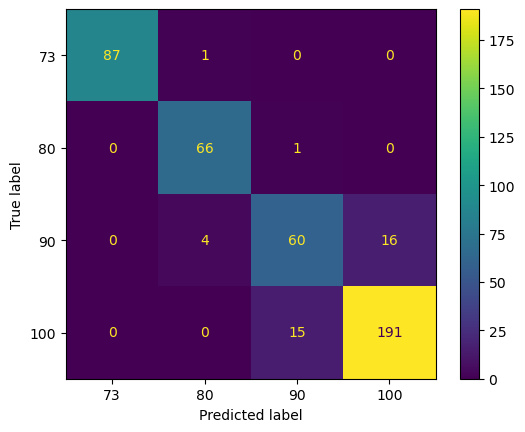

# Mögliche weitere Projekte

Mit den vorliegenden Daten sind noch viele andere Projekte denkbar, die Sie selbst ausprobieren können. 

Wir haben zum Beispiel oben mit dem CNN für den Kühler ein recht komplexes Modell trainiert. Da die Aufgabe recht einfach zu sein scheint, könnte man überprüfen, wie weit man hier zum Beispiel mit einem Entscheidungsbaum käme. Dieser könnte zum Beispiel die Mittelwerte und Standardabweichungen der Sensoren berücksichtigen sowie evtl. einen Mittelwert über die letzten paar Werte - da die Grafiken oben anzudeuten scheinen, dass bei Kühlerausfall die Temperatur gegen Ende der Zyklen steigt. 

Des Weiteren gibt es Daten von weiteren Sensoren, die wir hier noch gar nicht eingebunden haben. Es gibt zum Beispiel Daten zum Volumenfluss, die hier noch gar nicht berücksichtigt wurden. Möglicherweise sind auch sie prädiktiv für den Ventilzustand. Ebenso gibt es weitere Komponenten, für die wir hier noch kein Modell ausprobiert haben: den Hydrospeicher und die Pumpe. 

Eine weitere Möglichkeit wäre es, statt des Downsamplings der 100 Hz-Daten von den Drucksensoren Upsampling der Temperaturdaten auszuprobieren, wie oben bereits angemerkt. 

Schließlich gibt es auch noch den Marker, der die Stabilität des Durchlaufs angibt - wir haben bisher einfach alle Daten verwendet. Das heißt, es wurden auch Datenpunkte zum Training und zur Evaluation hinzugezogen, in denen das System noch gar keinen stabilen Zustand erreicht hatte. Es wäre daher interessant, auszuprobieren, ob die Modelle besser werden, wenn man nur Daten mit stabilem Zustand einbezieht. 

# Lizenzbedingungen des ursprünglichen Notebooks von Marco Cerliani

MIT License

Copyright (c) 2022 Marco Cerliani

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.